# Setup & Import Packages

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [4]:
import config

import pytz
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
from tqdm.notebook import tqdm as tqdm_notebook

# 1.1. Change size and scope

In [5]:
pr_df = pd.read_parquet(config.PR_DF_PATH)
pr_commits_df = pd.read_parquet(config.PR_COMMITS_DF_PATH)
pr_commit_details_df = pd.read_parquet(config.PR_COMMIT_DETAILS_DF_PATH)

human_pr_df = pd.read_parquet(config.HUMAN_PR_DF_PATH)
human_pr_commit_details_df = pd.read_parquet(config.HUMAN_PR_COMMIT_DETAILS_DF_PATH)

In [176]:
def load_pr_df_for_1_1_analysis(pr_df: pd.DataFrame) -> pd.DataFrame:
    pr_df = pr_df[['id', 'agent', 'created_at', 'closed_at', 'merged_at', 'state']]
    pr_df = pr_df.rename(columns={'id': 'pr_id'})
    pr_df['is_merged'] = np.where(pr_df['merged_at'].isna(), 0, 1)
    pr_df = pr_df[pr_df['closed_at'].isnull() == False]

    pr_df['created_at_dt'] = pd.to_datetime(pr_df['created_at'])
    pr_df = pr_df[pr_df['created_at_dt'].between(datetime(2025, 1, 1, tzinfo=pytz.UTC), datetime(2025, 7, 1, tzinfo=pytz.UTC))]
    pr_df.drop('created_at_dt', axis=1, inplace=True)
    logger.info(f"Loaded {pr_df.shape[0]} PRs for 1.1 analysis")
    logger.info(f"Unique PRs: {pr_df['pr_id'].nunique()}")
    return pr_df

In [177]:
def load_human_pr_df_for_1_1_analysis(human_pr_df: pd.DataFrame) -> pd.DataFrame:
    human_pr_df = human_pr_df[['id', 'agent', 'created_at', 'closed_at', 'merged_at', 'state']]
    human_pr_df = human_pr_df.rename(columns={'id': 'pr_id'})
    human_pr_df['is_merged'] = np.where(human_pr_df['merged_at'].isna(), 0, 1)
    human_pr_df = human_pr_df[human_pr_df['closed_at'].isnull() == False]
    
    human_pr_df['created_at_dt'] = pd.to_datetime(human_pr_df['created_at'])
    human_pr_df = human_pr_df[human_pr_df['created_at_dt'].between(datetime(2025, 1, 1, tzinfo=pytz.UTC), datetime(2025, 7, 1, tzinfo=pytz.UTC))]
    human_pr_df.drop('created_at_dt', axis=1, inplace=True)
    logger.info(f"Loaded {human_pr_df.shape[0]} PRs for 1.1 analysis")
    logger.info(f"Unique human PRs: {human_pr_df['pr_id'].nunique()}")
    return human_pr_df

In [178]:
pr_df_1_1 = load_pr_df_for_1_1_analysis(pr_df)

2025-11-06 16:24:20.547 | INFO     | __main__:load_pr_df_for_1_1_analysis:10 - Loaded 19196 PRs for 1.1 analysis
2025-11-06 16:24:20.548 | INFO     | __main__:load_pr_df_for_1_1_analysis:11 - Unique PRs: 19196


In [179]:
pr_df_1_1.head(1)

,pr_id,agent,created_at,closed_at,merged_at,state,is_merged
27,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0


In [180]:
human_pr_df_1_1 = load_human_pr_df_for_1_1_analysis(human_pr_df)

2025-11-06 16:24:20.899 | INFO     | __main__:load_human_pr_df_for_1_1_analysis:10 - Loaded 6149 PRs for 1.1 analysis
2025-11-06 16:24:20.900 | INFO     | __main__:load_human_pr_df_for_1_1_analysis:11 - Unique human PRs: 6149


In [181]:
human_pr_df_1_1.head(1)

,pr_id,agent,created_at,closed_at,merged_at,state,is_merged
0,2336888723,Human,2025-02-14T19:04:59Z,2025-02-18T22:42:20Z,2025-02-18T22:42:19Z,closed,1


In [182]:
def load_pr_commit_details_df_for_1_1_analysis(pr_commit_details_df: pd.DataFrame) -> pd.DataFrame:
    pr_commit_details_df = pr_commit_details_df[['pr_id', 'sha', 'filename', 'status', 'changes', 'additions', 'deletions']]
    logger.info(f"Loaded {pr_commit_details_df.shape[0]} PR commits for 1.1 analysis")
    logger.info(f"Unique PR commits: {pr_commit_details_df['pr_id'].nunique()}")
    return pr_commit_details_df

In [183]:
pr_commit_details_df_1_1 = load_pr_commit_details_df_for_1_1_analysis(pr_commit_details_df)
pr_commit_details_df_1_1.head(1)

2025-11-06 16:24:21.502 | INFO     | __main__:load_pr_commit_details_df_for_1_1_analysis:3 - Loaded 711923 PR commits for 1.1 analysis
2025-11-06 16:24:21.505 | INFO     | __main__:load_pr_commit_details_df_for_1_1_analysis:4 - Unique PR commits: 33580


,pr_id,sha,filename,status,changes,additions,deletions
0,3271196926,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,.github/workflows/compile-llms-txt.yml,added,38.0,38.0,0.0


In [184]:
def load_human_pr_commit_details_df_for_1_1_analysis(human_pr_commit_details_df: pd.DataFrame) -> pd.DataFrame:
    human_pr_commit_details_df = human_pr_commit_details_df[['pr_id', 'sha', 'file', 'status', 'changes', 'additions', 'deletions']]
    human_pr_commit_details_df = human_pr_commit_details_df.rename(columns={'file': 'filename'})
    logger.info(f"Loaded {human_pr_commit_details_df.shape[0]} human PR commits for 1.1 analysis")
    logger.info(f"Unique human PR commits: {human_pr_commit_details_df['pr_id'].nunique()}")
    return human_pr_commit_details_df

In [185]:
human_pr_commit_details_df_1_1 = load_human_pr_commit_details_df_for_1_1_analysis(human_pr_commit_details_df)
human_pr_commit_details_df_1_1.head(1)

2025-11-06 16:24:23.164 | INFO     | __main__:load_human_pr_commit_details_df_for_1_1_analysis:4 - Loaded 315472 human PR commits for 1.1 analysis
2025-11-06 16:24:23.166 | INFO     | __main__:load_human_pr_commit_details_df_for_1_1_analysis:5 - Unique human PR commits: 6603


,pr_id,sha,filename,status,changes,additions,deletions
0,2354816036,f76ad8971b774e58f2dd71fbdcb0cc669c1ab7f6,Cargo.lock,modified,1,1,0


In [186]:
def form_df_for_1_1_analysis(pr_df, pr_commit_details_df, human_pr_df, human_pr_commit_details_df):
    ai_combined = pr_df.merge(pr_commit_details_df, on='pr_id', how='inner')
    logger.info(f"There are {pr_df['pr_id'].nunique() - ai_combined['pr_id'].nunique()} PRs not found in pr_commit_details_df") # only 33580 PRs in pr_commit_details_df
    human_combined = human_pr_df.merge(human_pr_commit_details_df, on='pr_id', how='inner')
    logger.info(f"There are {human_pr_df['pr_id'].nunique() - human_combined['pr_id'].nunique()} PRs not found in human_pr_commit_details_df")
    result = pd.concat([ai_combined, human_combined], ignore_index=True)
    return result

In [187]:
df = form_df_for_1_1_analysis(pr_df_1_1, pr_commit_details_df_1_1, human_pr_df_1_1, human_pr_commit_details_df_1_1) # there are some PRs with no commit details.

2025-11-06 16:24:23.751 | INFO     | __main__:form_df_for_1_1_analysis:3 - There are 9 PRs not found in pr_commit_details_df
2025-11-06 16:24:23.785 | INFO     | __main__:form_df_for_1_1_analysis:5 - There are 14 PRs not found in human_pr_commit_details_df


In [188]:
df.head(2)

,pr_id,agent,created_at,closed_at,merged_at,state,is_merged,sha,filename,status,changes,additions,deletions
0,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/raw_websocket.go,added,222.0,222.0,0.0
1,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/server.go,modified,12.0,12.0,0.0


In [189]:
def add_is_agent_column(df):
    df['is_agent'] = np.where(df['agent'] == 'Human', 0, 1)
    return df

def add_ym_column(df):
    df['created_at_dt'] = pd.to_datetime(df['created_at'])
    df['created_at_ym'] = df['created_at_dt'].dt.strftime('%Y-%m')
    df.drop('created_at_dt', axis=1, inplace=True)
    return df

In [190]:
df = add_is_agent_column(df)
df = add_ym_column(df)
df.head(2)

,pr_id,agent,created_at,closed_at,merged_at,state,is_merged,sha,filename,status,changes,additions,deletions,is_agent,created_at_ym
0,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/raw_websocket.go,added,222.0,222.0,0.0,1,2025-06
1,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/server.go,modified,12.0,12.0,0.0,1,2025-06


In [191]:
def add_module_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['_path_parts'] = df['filename'].str.split('/')
    condition_l1 = df['_path_parts'].str.len() >= 2
    df['module_l1'] = np.nan
    df.loc[condition_l1, 'module_l1'] = df.loc[condition_l1, '_path_parts'].str[-2]
    
    condition_l2 = df['_path_parts'].str.len() >= 3
    df['module_l2'] = np.nan
    df.loc[condition_l2, 'module_l2'] = df.loc[condition_l2, '_path_parts'].str[-3]
    
    df.drop('_path_parts', axis=1, inplace=True)
    return df

In [192]:
df = add_module_columns(df)
df.head(1)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_50084/2098982215.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['api' 'api' 'session' ... 'login' 'signup' 'src']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[condition_l1, 'module_l1'] = df.loc[condition_l1, '_path_parts'].str[-2]
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_50084/2098982215.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['pkg' 'pkg' 'pkg' ... 'app' 'app' 'web']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[condition_l2, 'module_l2'] = df.loc[condition_l2, '_path_parts'].str[-3]


,pr_id,agent,created_at,closed_at,merged_at,state,is_merged,sha,filename,status,changes,additions,deletions,is_agent,created_at_ym,module_l1,module_l2
0,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/raw_websocket.go,added,222.0,222.0,0.0,1,2025-06,api,pkg


In [230]:
def add_task_type_column(df: pd.DataFrame) -> pd.DataFrame:
    pr_task_type_df = pd.read_parquet(config.PR_TASK_TYPE_DF_PATH)
    human_task_type_df = pd.read_parquet(config.HUMAN_PR_TASK_TYPE_DF_PATH)
    human_task_type_df = human_task_type_df[['id', 'type']]
    pr_task_type_df = pr_task_type_df[['id', 'type']]
    combined_df = pd.concat([human_task_type_df, pr_task_type_df], ignore_index=True)
    combined_df.columns = ['pr_id', 'task_type']
    result_df = df.merge(combined_df, on='pr_id', how='left')
    assert result_df.shape[0] == df.shape[0], "Join must be 1:1" 
    return result_df

In [231]:
df = pd.read_parquet(config.ANALYSIS_1_1_DF_PATH)

In [232]:
df = add_task_type_column(df)
df.head(1)

,pr_id,agent,created_at,closed_at,merged_at,state,is_merged,sha,filename,status,changes,additions,deletions,is_agent,created_at_ym,module_l1,module_l2,task_type
0,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/raw_websocket.go,added,222.0,222.0,0.0,1,2025-06,api,pkg,fix


In [233]:
df.to_parquet(config.ANALYSIS_1_1_DF_PATH, index=False, engine='pyarrow')

In [234]:
def stats_for_number_pr_merge(df: pd.DataFrame, is_agent: bool = True) -> pd.DataFrame:
    df = df[df['is_agent'] == is_agent]
    grp = df.groupby(['created_at_ym', 'is_merged'])['pr_id'].nunique().unstack().reset_index()
    grp['total_prs'] = grp[0] + grp[1]
    grp['merge_rate'] = grp[1] / grp['total_prs']
    return grp

In [235]:
grp = stats_for_number_pr_merge(df, is_agent=True)
grp


is_merged,created_at_ym,0,1,total_prs,merge_rate
0,2025-01,236,175,411,0.425791
1,2025-02,322,209,531,0.393597
2,2025-03,369,367,736,0.498641
3,2025-04,320,490,810,0.604938
4,2025-05,1399,3999,5398,0.740830
5,2025-06,2250,9051,11301,0.800903


In [236]:
grp = stats_for_number_pr_merge(df, is_agent=False)
grp


is_merged,created_at_ym,0,1,total_prs,merge_rate
0,2025-01,149,755,904,0.835177
1,2025-02,193,767,960,0.798958
2,2025-03,232,863,1095,0.788128
3,2025-04,148,937,1085,0.863594
4,2025-05,176,909,1085,0.837788
5,2025-06,156,850,1006,0.844930


In [237]:
def stats_for_commit_changes(df: pd.DataFrame, is_agent: bool = True) -> pd.DataFrame:
    df = df[df['is_agent'] == is_agent]
    grp_by_pr = df.groupby(['pr_id', 'created_at_ym']).agg({
        'changes': 'sum',
        'additions': 'sum',
        'deletions': 'sum',
        'filename': 'nunique',
        'sha': 'nunique',
        'module_l1': 'nunique',
        'module_l2': 'nunique',
    }).reset_index()
    grp_by_pr.columns = ['pr_id', 'created_at_ym', 'sum_changes', 'additions', 'deletions', 'num_file_changes', 'num_commits', 'num_module_l1', 'num_module_l2']
    
    grp = grp_by_pr.groupby(['created_at_ym']).agg({
        'sum_changes': 'sum',
        'additions': 'sum',
        'deletions': 'sum',
        'num_file_changes': 'mean',
        'num_commits': 'mean',
        'num_module_l1': 'mean',
        'num_module_l2': 'mean',
    }).reset_index()
    
    return grp

In [238]:
grp = stats_for_commit_changes(df, is_agent=True)
grp


,created_at_ym,sum_changes,additions,deletions,num_file_changes,num_commits,num_module_l1,num_module_l2
0,2025-01,2287904.0,1254058.0,1033846.0,23.082725,5.447689,7.571776,4.469586
1,2025-02,1894698.0,1039526.0,855172.0,19.374765,5.657250,7.203390,3.615819
2,2025-03,1191901.0,892883.0,299018.0,24.907609,4.203804,8.330163,4.191576
3,2025-04,1941275.0,1146600.0,794675.0,29.993827,5.293827,10.951852,6.071605
4,2025-05,8210076.0,5109803.0,3100273.0,14.422934,2.684328,4.752130,2.651538
5,2025-06,15910654.0,10337783.0,5572871.0,12.519689,2.299354,3.916733,2.345810


In [239]:
grp['deletions'].sum()

np.float64(11655855.0)

In [240]:
grp = stats_for_commit_changes(df, is_agent=False)
grp


,created_at_ym,sum_changes,additions,deletions,num_file_changes,num_commits,num_module_l1,num_module_l2
0,2025-01,3051883.0,2073975.0,977908.0,35.459071,3.857301,10.490044,5.353982
1,2025-02,3474563.0,2083556.0,1391007.0,35.518750,4.343750,10.870833,5.634375
2,2025-03,3012923.0,1997910.0,1015013.0,38.730594,3.890411,11.579909,6.135160
3,2025-04,3304298.0,1957376.0,1346922.0,33.835023,3.978802,10.626728,6.008295
4,2025-05,5159887.0,3563122.0,1596765.0,31.717972,4.288479,9.037788,5.425806
5,2025-06,2501369.0,1534658.0,966711.0,25.436382,3.299205,7.687873,4.219682


In [362]:
def plot_violin_stats(df: pd.DataFrame) -> None:
    """
    Create split violin plots comparing APR vs HPR for:
    - Changed Files Count
    - Added Lines (log scale)
    - Deleted Lines (log scale)
    
    APR on the right side, HPR on the left side, touching in the middle.
    """
    # Aggregate by PR  
    grp = df.groupby(['pr_id', 'is_agent']).agg(
        {
            'filename': 'nunique',
            'additions': 'sum',
            'deletions': 'sum',
        }
    ).reset_index()
    grp.columns = ['pr_id', 'is_agent', 'num_file_changes', 'total_added_lines', 'total_deleted_lines']
    
    # Map is_agent to group names
    grp['Group'] = grp['is_agent'].map({1: 'APR', 0: 'HPR'})
    
    # Add a dummy category for split violins to share same position
    grp['Category'] = ''  # Single category for all data
    
    # Filter out zero values for log scale plots
    file_changes_nonzero = grp[(grp['num_file_changes'] > 0)]
    added_nonzero = grp[(grp['total_added_lines'] > 0)]
    deleted_nonzero = grp[(grp['total_deleted_lines'] > 0)]
    file_changes_nonzero['Category'] = ''
    added_nonzero['Category'] = ''
    deleted_nonzero['Category'] = ''
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Color palette matching the image
    colors = {'APR': '#E07A7A', 'HPR': '#7AA8D9'}
    
    # Plot 1: Changed Files Count (split violin)
    sns.violinplot(
        data=file_changes_nonzero, 
        x='Category',  # Single category so violins share position
        y='num_file_changes',
        hue='Group',
        hue_order=['HPR', 'APR'],  # HPR left, APR right
        split=True,
        palette=colors,
        ax=axes[0],
        inner='box'
    )
    axes[0].set_xlabel('')
    axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axes[0].set_ylabel('Changed Files Count', fontsize=12)
    axes[0].set_yscale('log')
    axes[0].set_ylim(0.8, file_changes_nonzero['num_file_changes'].max() * 1.5)
    axes[0].grid(True, alpha=0.3)
    axes[0].get_legend().remove()
    
    # Plot 2: Added Lines (log scale, split violin)
    sns.violinplot(
        data=added_nonzero, 
        x='Category',
        y='total_added_lines',
        hue='Group',
        hue_order=['HPR', 'APR'],
        split=True,
        palette=colors,
        ax=axes[1],
        inner='box'
    )
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axes[1].set_ylabel('Added Lines', fontsize=12)
    axes[1].set_yscale('log')
    axes[1].set_ylim(0.5, added_nonzero['total_added_lines'].max() * 1.5)
    axes[1].grid(True, alpha=0.3)
    axes[1].get_legend().remove()
    
    # Plot 3: Deleted Lines (log scale, split violin)
    sns.violinplot(
        data=deleted_nonzero, 
        x='Category',
        y='total_deleted_lines',
        hue='Group',
        hue_order=['HPR', 'APR'],
        split=True,
        palette=colors,
        ax=axes[2],
        inner='box'
    )
    axes[2].set_xlabel('')
    axes[2].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axes[2].set_ylabel('Deleted Lines', fontsize=12)
    axes[2].set_yscale('log')
    axes[2].set_ylim(0.5, deleted_nonzero['total_deleted_lines'].max() * 1.5)
    axes[2].grid(True, alpha=0.3)
    
    # Keep only the legend from the last plot
    axes[2].legend(title='Group', loc='upper right')
    
    plt.tight_layout()
    plt.show()
    return grp, file_changes_nonzero, added_nonzero, deleted_nonzero

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_50084/3212846296.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_changes_nonzero['Category'] = ''
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_50084/3212846296.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  added_nonzero['Category'] = ''
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_50084/3212846296.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

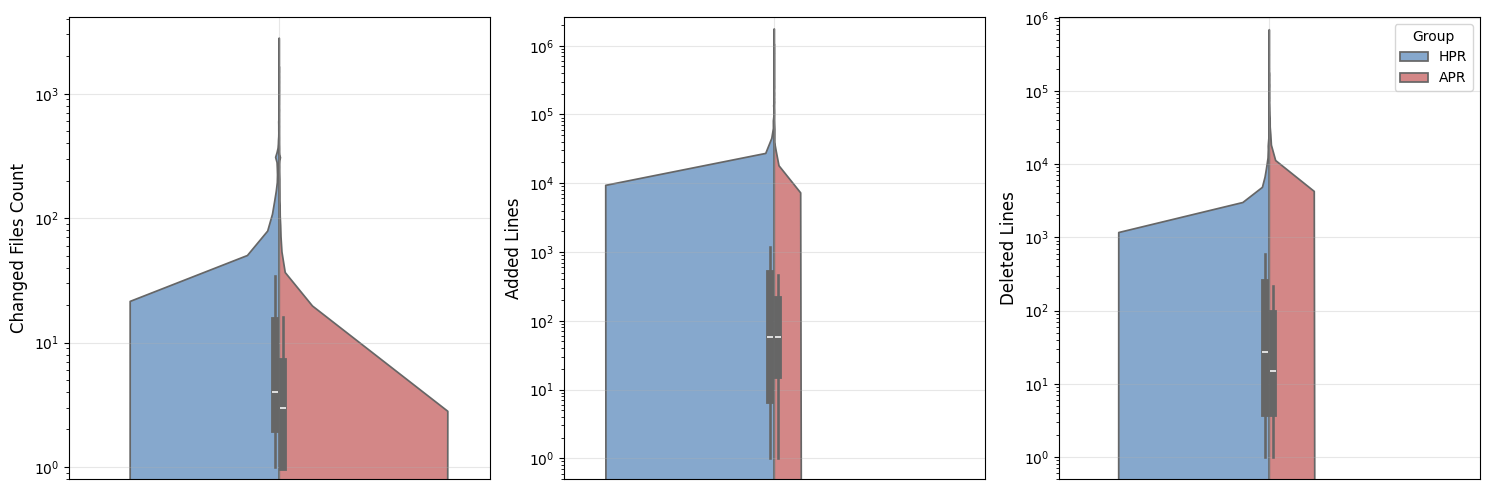

In [363]:
grp, file_changes_nonzero, added_nonzero, deleted_nonzero = plot_violin_stats(df)

In [364]:
deleted_nonzero.groupby('Group')['total_deleted_lines'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
APR,15199.0,766.883019,9317.741820,1.0,4.0,15.0,89.0,682813.0
HPR,5751.0,1268.357851,7035.155561,1.0,4.0,27.0,239.0,175807.0


In [366]:
added_nonzero.groupby('Group')['total_added_lines'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
APR,18728.0,1056.207443,12458.675009,1.0,16.0,59.0,197.00,1053409.0
HPR,6040.0,2187.184934,24209.278555,1.0,7.0,58.0,470.75,1744040.0


In [367]:
file_changes_nonzero.groupby('Group')['num_file_changes'].describe()


,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
APR,18925.0,14.887292,54.008446,1.0,1.0,3.0,7.0,1641.0
HPR,6135.0,33.459984,105.601051,1.0,2.0,4.0,15.0,2765.0


In [246]:
grp.head()

,pr_id,is_agent,num_file_changes,total_added_lines,total_deleted_lines,Group,Category
0,2256770133,0,3,135.0,23.0,HPR,
1,2256773596,0,15,2085.0,193.0,HPR,
2,2256777953,0,1,1.0,1.0,HPR,
3,2256824367,0,131,9126.0,7186.0,HPR,
4,2256920866,0,6,124.0,118.0,HPR,


In [368]:
def test_mannwhitneyu(grp: pd.DataFrame, metric: str, alpha: float = 0.05) -> None:
    if 'Group' not in grp.columns:
        raise ValueError("Group column is required for this function.")
    
    grp_a = grp[grp['Group'] == 'APR'][metric]
    grp_b = grp[grp['Group'] == 'HPR'][metric]
    
    u_statistic, p_value = mannwhitneyu(grp_a, grp_b, alternative='two-sided')
    if p_value < alpha:
        logger.success(f"At {alpha} significance level, the difference in {metric} is statistically significant.")
        logger.info(f"P-value: {p_value:.4f}")
    else:
        logger.warning(f"At {alpha} significance level, the difference in {metric} is NOT statistically significant.")
        logger.info(f"P-value: {p_value:.4f}")
    

In [369]:
test_mannwhitneyu(file_changes_nonzero, 'num_file_changes', alpha=0.05)

2025-11-06 22:04:49.859 | SUCCESS  | __main__:test_mannwhitneyu:10 - At 0.05 significance level, the difference in num_file_changes is statistically significant.
2025-11-06 22:04:49.859 | INFO     | __main__:test_mannwhitneyu:11 - P-value: 0.0000


In [370]:
test_mannwhitneyu(added_nonzero, 'total_added_lines', alpha=0.05)

2025-11-06 22:04:53.957 | WARNING  | __main__:test_mannwhitneyu:13 - At 0.05 significance level, the difference in total_added_lines is NOT statistically significant.
2025-11-06 22:04:53.957 | INFO     | __main__:test_mannwhitneyu:14 - P-value: 0.2866


In [371]:
test_mannwhitneyu(deleted_nonzero, 'total_deleted_lines', alpha=0.05)

2025-11-06 22:05:02.311 | SUCCESS  | __main__:test_mannwhitneyu:10 - At 0.05 significance level, the difference in total_deleted_lines is statistically significant.
2025-11-06 22:05:02.312 | INFO     | __main__:test_mannwhitneyu:11 - P-value: 0.0000


In [251]:
def aggregate_to_pr_level(df: pd.DataFrame) -> pd.DataFrame:
    grp = df.groupby(['pr_id', 'is_agent']).agg({
        'sha': 'nunique',
        'module_l1': 'nunique',
    }).reset_index()
    grp.columns = ['pr_id', 'Group', 'num_commits', 'num_module_l1']
    # map 1,0 to HPR, APR
    grp['Group'] = grp['Group'].map({1: 'APR', 0: 'HPR'})
    return grp

In [252]:
grp = aggregate_to_pr_level(df)

In [253]:
test_mannwhitneyu(grp, 'num_commits', alpha=0.05)

2025-11-06 19:04:11.307 | SUCCESS  | __main__:test_mannwhitneyu:10 - At 0.05 significance level, the difference in num_commits is statistically significant.
2025-11-06 19:04:11.308 | INFO     | __main__:test_mannwhitneyu:11 - P-value: 0.0000


In [254]:
test_mannwhitneyu(grp, 'num_module_l1', alpha=0.05)


2025-11-06 19:04:12.903 | SUCCESS  | __main__:test_mannwhitneyu:10 - At 0.05 significance level, the difference in num_module_l1 is statistically significant.
2025-11-06 19:04:12.904 | INFO     | __main__:test_mannwhitneyu:11 - P-value: 0.0000


In [255]:
def stats_task_type(df: pd.DataFrame) -> pd.DataFrame:
    grp = df.groupby(['task_type', 'is_agent']).agg({
        'pr_id': 'nunique',
    }).reset_index()
    grp.columns = ['task_type', 'is_agent', 'num_prs']
    grp['total_prs'] = grp.groupby('is_agent')['num_prs'].transform('sum')
    grp['pr_rate'] = grp['num_prs'] / grp['total_prs']
    return grp

In [256]:
grp = stats_task_type(df)

In [259]:
df.groupby('is_agent')['pr_id'].nunique()

is_agent
0     6135
1    19187
Name: pr_id, dtype: int64

In [263]:
grp.pivot_table(index='task_type', columns='is_agent', values='pr_rate', aggfunc='mean').sort_values(1, ascending=False)

is_agent,0,1
task_type,,
feat,0.284760,0.379528
fix,0.271883,0.253661
docs,0.074654,0.142961
test,0.029014,0.074842
refactor,0.055909,0.073018
chore,0.133170,0.031271
build,0.096007,0.017356
ci,0.015811,0.009538
perf,0.012062,0.009277


In [284]:
def test_mannwhitneyu_new(grp: pd.DataFrame, column: str, metric: str, groupa: str, groupb: str, alpha: float = 0.05) -> None:
    if column not in grp.columns:
        raise ValueError(f"{column} is not in the dataframe.")
    
    grp_a = grp[grp[column] == groupa][metric]
    grp_b = grp[grp[column] == groupb][metric]
    
    u_statistic, p_value = mannwhitneyu(grp_a, grp_b, alternative='two-sided')
    if p_value < alpha:
        logger.success(f"At {alpha} significance level, the difference in {metric} is statistically significant.")
        logger.info(f"P-value: {p_value:.4f}")
    else:
        logger.warning(f"At {alpha} significance level, the difference in {metric} is NOT statistically significant.")
        logger.info(f"P-value: {p_value:.4f}")
    

In [300]:
check = df.copy()

In [301]:
check['task_type_new'] = check['task_type'].map({
        'build': 'build & chore',
        'chore': 'build & chore',
        'test': 'test & docs',
        'docs': 'test & docs',
    })

In [291]:
def stats_commits_by_task_type(df: pd.DataFrame) -> pd.DataFrame:
    df['task_type_new'] = df['task_type'].map({
        'build': 'build & chore',
        'chore': 'build & chore',
        'test': 'test & docs',
        'docs': 'test & docs',
    })
    agg_to_pr_level = df.groupby(['pr_id', 'task_type_new']).agg({
        'filename': 'nunique',
        'additions': 'sum',
        'deletions': 'sum',
    }).reset_index()

    agg_to_pr_level.columns = ['pr_id', 'task_type', 'num_file_changes', 'additions', 'deletions']

    return agg_to_pr_level

In [353]:
grp_nonzero.groupby('Group')['total_deleted_lines'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
APR,15014.0,770.719395,9365.012042,1.0,4.0,15.0,89.0,682813.0
HPR,5668.0,1246.580628,6896.923918,1.0,4.0,27.0,243.0,175807.0


In [296]:
grp = stats_commits_by_task_type(df)

In [298]:
grp.head()

,pr_id,task_type,num_file_changes,additions,deletions
0,2256777953,build & chore,1,1.0,1.0
1,2257022379,build & chore,1,1.0,1.0
2,2257025799,build & chore,2,169.0,137.0
3,2257213950,build & chore,1,1.0,1.0
4,2257308227,build & chore,1,1.0,1.0


In [289]:
test_mannwhitneyu_new(grp, 'task_type', 'num_file_changes', 'build & chore', 'test & docs', alpha=0.05)

2025-11-06 20:46:54.985 | SUCCESS  | __main__:test_mannwhitneyu_new:10 - At 0.05 significance level, the difference in num_file_changes is statistically significant.
2025-11-06 20:46:54.986 | INFO     | __main__:test_mannwhitneyu_new:11 - P-value: 0.0001


In [344]:
grp[grp['num_file_changes'] > 1000]

,pr_id,task_type,num_file_changes,additions,deletions
509,2343922182,build & chore,1164,48604.0,32362.0
637,2366301215,build & chore,1009,90592.0,10120.0
4673,3119512382,build & chore,1417,58821.0,39658.0
6815,3178456167,test & docs,1060,30315.0,50096.0


In [ ]:
pr_df[pr_df['id'] == 2343922182]['html_url'].values

array([], dtype=object)

In [347]:
human_pr_df[human_pr_df['id'] == 2343922182]['html_url'].values

array(['https://github.com/Azure/azure-sdk-for-js/pull/33127'],
      dtype=object)

In [341]:
human_pr_commit_details_df[human_pr_commit_details_df['pr_id'] == 3119512382].shape

(0, 12)

In [318]:
pr_df.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625


In [322]:
human_pr_df[human_pr_df['id'] == 2366301215]['html_url'].values

array(['https://github.com/Azure/azure-rest-api-specs/pull/32930'],
      dtype=object)

In [290]:
grp.groupby('task_type')['num_file_changes'].describe()

,count,mean,std,min,25%,50%,75%,max
task_type,,,,,,,,
build & chore,2339.0,21.073536,78.455584,0.0,1.0,2.0,7.0,1417.0
test & docs,1614.0,13.175960,51.540750,0.0,1.0,2.0,6.0,784.0


In [303]:
test_mannwhitneyu_new(grp, 'task_type', 'additions', 'build & chore', 'test & docs', alpha=0.05)

2025-11-06 20:52:01.376 | SUCCESS  | __main__:test_mannwhitneyu_new:10 - At 0.05 significance level, the difference in additions is statistically significant.
2025-11-06 20:52:01.377 | INFO     | __main__:test_mannwhitneyu_new:11 - P-value: 0.0000


In [304]:
grp.groupby('task_type')['additions'].describe()

,count,mean,std,min,25%,50%,75%,max
task_type,,,,,,,,
build & chore,2339.0,1338.922617,9931.779803,0.0,3.0,17.0,163.5,331256.0
test & docs,4815.0,844.989200,15843.056447,0.0,10.0,36.0,122.0,1053409.0


In [305]:
test_mannwhitneyu_new(grp, 'task_type', 'deletions', 'build & chore', 'test & docs', alpha=0.05)
grp.groupby('task_type')['deletions'].describe()


2025-11-06 20:53:17.899 | SUCCESS  | __main__:test_mannwhitneyu_new:10 - At 0.05 significance level, the difference in deletions is statistically significant.
2025-11-06 20:53:17.899 | INFO     | __main__:test_mannwhitneyu_new:11 - P-value: 0.0000


,count,mean,std,min,25%,50%,75%,max
task_type,,,,,,,,
build & chore,2339.0,1182.042753,9022.360482,0.0,2.0,11.0,118.5,312167.0
test & docs,4815.0,322.769055,2429.741452,0.0,0.0,2.0,21.0,97421.0


# 1.2 Rework tendency

In [6]:
import re
from tree_sitter import Language, Parser
# Load built-in Tree-sitter languages
from tree_sitter_languages import get_language

# Supported languages map
LANGUAGES = {
    "python": get_language("python"),
    "typescript": get_language("typescript"),
    "javascript": get_language("javascript"),
    "go": get_language("go"),
    "c_sharp": get_language("c_sharp"),
    "java": get_language("java"),
    "cpp": get_language("cpp"),
}

In [7]:
EXT_TO_LANG = {
    ".py": "python",
    ".pyi": "python",
    ".pyw": "python",

    ".js": "javascript",
    ".jsx": "javascript",
    ".mjs": "javascript",
    ".cjs": "javascript",

    ".ts": "typescript",
    ".tsx": "typescript",

    ".cpp": "cpp",
    ".cc": "cpp",
    ".cxx": "cpp",
    ".c++": "cpp",

    ".java": "java",

    ".cs": "c-sharp",

    ".go": "go",
}


def detect_lang_from_filename(filename: str):
    """Detect programming language from filename extension."""
    _, ext = os.path.splitext(filename.lower())
    return EXT_TO_LANG.get(ext)


In [8]:
# ============================================================================
# TREE-SITTER BASED FUNCTION/CLASS EXTRACTION FROM PATCH DIFFS
# ============================================================================

def parse_patch_to_code_versions(patch: str):
    """
    Parse a unified diff patch to extract old and new code versions.
    
    Args:
        patch: Unified diff string
        
    Returns:
        tuple: (old_code, new_code) as strings, or (None, None) if parsing fails
    """
    if not patch:
        return None, None
    
    old_lines = []
    new_lines = []
    
    for line in patch.split('\n'):
        if line.startswith('---') or line.startswith('+++') or line.startswith('@@'):
            continue
        elif line.startswith('-'):
            # Line removed from old version
            old_lines.append(line[1:])
        elif line.startswith('+'):
            # Line added to new version
            new_lines.append(line[1:])
        else:
            # Context line (present in both)
            old_lines.append(line[1:] if line.startswith(' ') else line)
            new_lines.append(line[1:] if line.startswith(' ') else line)
    
    old_code = '\n'.join(old_lines)
    new_code = '\n'.join(new_lines)
    
    return old_code, new_code


def extract_symbols_with_treesitter(code: str, language: str):
    """
    Extract function and class definitions from code using Tree-sitter.
    
    Args:
        code: Source code string
        language: Language name (must be in LANGUAGES dict)
        
    Returns:
        dict: {'functions': set(), 'classes': set()}
    """
    symbols = {'functions': set(), 'classes': set()}
    
    if not code or not code.strip():
        return symbols
    
    # Map language names to Tree-sitter language objects
    lang_mapping = {
        'python': 'python',
        'javascript': 'javascript',
        'java': 'java',
        'cpp': 'cpp',
        'c-sharp': 'c_sharp',
        'go': 'go',
        'typescript': 'typescript',
    }
    
    ts_lang_name = lang_mapping.get(language)
    if not ts_lang_name or ts_lang_name not in LANGUAGES:
        logger.warning(f"Language {language} not supported by program")
        return symbols
    
    try:
        # Create parser
        parser = Parser()
        parser.set_language(LANGUAGES[ts_lang_name])
        
        # Parse the code
        tree = parser.parse(bytes(code, 'utf8'))
        root_node = tree.root_node
        
        # Define queries for different languages
        if ts_lang_name == 'python':
            function_types = ['function_definition']
            class_types = ['class_definition']
            name_field = 'name'
            
        elif ts_lang_name == 'javascript':
            function_types = ['function_declaration', 'function_expression', 
                            'arrow_function', 'method_definition']
            class_types = ['class_declaration']
            name_field = 'name'
            
        elif ts_lang_name == 'java':
            function_types = ['method_declaration', 'constructor_declaration']
            class_types = ['class_declaration', 'interface_declaration']
            name_field = 'name'
            
        elif ts_lang_name == 'cpp':
            function_types = ['function_definition', 'function_declarator']
            class_types = ['class_specifier', 'struct_specifier']
            name_field = 'declarator'
            
        elif ts_lang_name == 'c_sharp':
            function_types = ['method_declaration', 'constructor_declaration']
            class_types = ['class_declaration', 'interface_declaration']
            name_field = 'name'
        elif ts_lang_name == 'go':
            function_types = ['function_declaration']
            class_types = ['type_declaration']
            name_field = 'name'
        elif ts_lang_name == 'typescript':
            function_types = ['function_declaration', 'function_expression', 'arrow_function', 'method_definition']
            class_types = ['class_declaration']
            name_field = 'name'
        else:
            return symbols
        
        # Traverse tree to find function and class definitions
        def traverse(node):
            if node.type in function_types:
                name_node = node.child_by_field_name(name_field)
                if name_node:
                    symbols['functions'].add(name_node.text.decode('utf8'))
                elif node.children:
                    # Fallback: try to find identifier in children
                    for child in node.children:
                        if child.type == 'identifier':
                            symbols['functions'].add(child.text.decode('utf8'))
                            break
            
            if node.type in class_types:
                name_node = node.child_by_field_name(name_field)
                if name_node:
                    symbols['classes'].add(name_node.text.decode('utf8'))
                elif node.children:
                    # Fallback: try to find identifier in children
                    for child in node.children:
                        if child.type == 'identifier':
                            symbols['classes'].add(child.text.decode('utf8'))
                            break
            
            # Recurse through children
            for child in node.children:
                traverse(child)
        
        traverse(root_node)
        
    except Exception as e:
        raise e
    
    return symbols


def extract_changes_from_patch(patch: str, language: str) -> dict:
    """
    Extract added and removed functions/classes from a patch diff.
    
    IMPLEMENTATION:
    Step 1: Split diff into old_code and new_code
    Step 2: Use Tree-sitter parsing for structural extraction
    Step 3: Compare symbol sets to identify added/removed
    
    Args:
        patch: Unified diff string
        language: Programming language (must match EXT_TO_LANG values)
        
    Returns:
        dict: {
            'added_functions': set(),
            'removed_functions': set(),
            'added_classes': set(),
            'removed_classes': set()
        }
    """
    result = {
        'added_functions': set(),
        'removed_functions': set(),
        'added_classes': set(),
        'removed_classes': set()
    }
    
    if not patch or not language:
        return result
    
    # STEP 1: Split diff into old_code and new_code
    old_code, new_code = parse_patch_to_code_versions(patch)
    
    if old_code is None or new_code is None:
        return result
    
    # STEP 2: Try Tree-sitter parsing for structural extraction
    try:
        old_symbols = extract_symbols_with_treesitter(old_code, language)
    except Exception as e:
        raise e
    try:
        new_symbols = extract_symbols_with_treesitter(new_code, language)
    except Exception as e:
        raise e
    
    # STEP 3: Compare symbol sets to identify added/removed
    result['added_functions'] = new_symbols['functions'] - old_symbols['functions']
    result['removed_functions'] = old_symbols['functions'] - new_symbols['functions']
    result['added_classes'] = new_symbols['classes'] - old_symbols['classes']
    result['removed_classes'] = old_symbols['classes'] - new_symbols['classes']
    
    return result


def analyze_patch_changes(patch: str, filename: str):
    """
    High-level function to analyze a patch and extract all changes.
    
    Args:
        patch: Unified diff string
        filename: Filename to detect language
        
    Returns:
        dict: Change analysis results
    """
    # Detect language from filename
    language = detect_lang_from_filename(filename)
    
    if not language:
        raise ValueError(f"Language not supported: {filename}")
    
    try:
        changes = extract_changes_from_patch(patch, language)
        changes['language'] = language
    except Exception as e:
        logger.error(f"Error analyzing patch for {filename}: {e}")
        return {
            'language': None,
            'added_functions': set(),
            'removed_functions': set(),
            'added_classes': set(),
            'removed_classes': set(),
            'error': str(e)
        }   
    return changes


def extract_changes_for_df(row):
    """
    Extract function/class changes from a DataFrame row.
    Designed to be used with pandas DataFrame.apply().
    
    Args:
        row: pandas Series with 'patch' and 'filename' columns
        
    Returns:
        pandas Series with 4 columns containing sets:
        - added_functions: set of function names added
        - added_classes: set of class names added  
        - removed_functions: set of function names removed
        - removed_classes: set of class names removed
        
    Usage:
        df[['added_functions', 'added_classes', 'removed_functions', 'removed_classes']] = \\
            df.apply(extract_changes_for_df, axis=1)
            
        # Or with progress bar:
        from tqdm import tqdm
        tqdm.pandas()
        df[['added_functions', 'added_classes', 'removed_functions', 'removed_classes']] = \\
            df.progress_apply(extract_changes_for_df, axis=1)
    """
    # Define column names and order
    cols = ['added_functions', 'added_classes', 'removed_functions', 'removed_classes']
    
    # Handle missing values
    if pd.isna(row['patch']) or pd.isna(row['filename']):
        return pd.Series([set(), set(), set(), set()], index=cols, dtype=object)
    
    try:
        # Detect language from filename
        language = detect_lang_from_filename(row['filename'])
        
        if not language:
            return pd.Series([set(), set(), set(), set()], index=cols, dtype=object)
        
        # Extract changes
        changes = extract_changes_from_patch(row['patch'], language)
        
        # Return as Series with explicit index and dtype
        return pd.Series([
            changes['added_functions'],
            changes['added_classes'],
            changes['removed_functions'],
            changes['removed_classes']
        ], index=cols, dtype=object)
        
    except Exception as e:
        # Log error but don't break the pipeline
        logger.debug(f"Error processing {row.get('filename', 'unknown')}: {e}")
        return pd.Series([set(), set(), set(), set()], index=cols, dtype=object)


In [9]:
def load_pr_commit_details_1_2(df: pd.DataFrame) -> pd.DataFrame:
    df = df[['pr_id', 'filename', 'patch', 'status']]
    df = df[df['patch'].isnull() == False]
    return df

In [10]:
df_1_2 = load_pr_commit_details_1_2(pr_commit_details_df)

In [11]:
df_1_2['prog_lang'] = df_1_2['filename'].apply(detect_lang_from_filename)

In [12]:
df_1_2.head()

,pr_id,filename,patch,status,prog_lang
0,3271196926,.github/workflows/compile-llms-txt.yml,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n...",added,None
1,3271196926,docs/compile_llms_txt.py,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im...",added,python
3,3271196926,docs/compile_llms_txt.py,"@@ -1,47 +1,48 @@\n import os\n from pathlib i...",modified,python
4,3271196926,docs/compile_llms_txt.py,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt...",modified,python
6,3271196926,docs/compile_llms_txt.py,"@@ -1,29 +1,34 @@\n-import os\n from pathlib i...",modified,python


In [13]:
df_1_2 = df_1_2[df_1_2['prog_lang'].isnull() == False]

In [14]:
df_1_2.isnull().sum()/df_1_2.shape[0]

pr_id        0.0
filename     0.0
patch        0.0
status       0.0
prog_lang    0.0
dtype: float64

In [15]:
df_1_2.groupby('prog_lang')['pr_id'].nunique()

prog_lang
c-sharp       1638
cpp            505
go            7784
java          1583
javascript    2413
python        5187
typescript    6820
Name: pr_id, dtype: int64

In [16]:
df_1_2 = df_1_2.reset_index(drop=True)

In [17]:
df_1_2[df_1_2['filename'] == "examples/sql-editor/src/MainView.tsx"]

,pr_id,filename,patch,status,prog_lang
230048,3071661822,examples/sql-editor/src/MainView.tsx,"@@ -0,0 +1,79 @@\n+import {\n+ CreateTableMod...",added,typescript


In [18]:
df_1_2.shape

(292703, 5)

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="Extracting changes")
df_1_2[['added_functions', 'added_classes', 'removed_functions', 'removed_classes']] = \
    df_1_2.progress_apply(extract_changes_for_df, axis=1)

Extracting changes:  17%|█▋        | 49905/292703 [00:28<02:14, 1798.89it/s]

In [399]:
repo_df = pd.read_parquet(config.REPO_DF_PATH)

In [400]:
repo_df.head()

,id,url,license,full_name,language,forks,stars
0,966235850,https://api.github.com/repos/kizuna-ai-lab/sokuji,AGPL-3.0,kizuna-ai-lab/sokuji,TypeScript,11,254
1,386644013,https://api.github.com/repos/freenet/freenet-core,NOASSERTION,freenet/freenet-core,Rust,94,2391
2,977155585,https://api.github.com/repos/coleam00/mcp-craw...,MIT,coleam00/mcp-crawl4ai-rag,Python,474,1447
3,528194129,https://api.github.com/repos/vexxhost/atmosphere,None,vexxhost/atmosphere,Smarty,34,142
4,703998226,https://api.github.com/repos/JonasKruckenberg/k23,Apache-2.0,JonasKruckenberg/k23,Rust,32,515


In [13]:
tmp = pr_df[['id', 'is_merged', 'agent']]
tmp.columns = ['pr_id', 'is_merged', 'agent']
me_df = gr.merge(tmp, on='pr_id', how='left')


In [14]:
me_df.head()

,pr_id,num_file_changes,num_commits,sum_changes,is_merged,agent
0,2756921963,15,16,1192.0,0,Devin
1,2757103560,16,10,779.0,0,Devin
2,2757124156,1,1,2.0,0,Devin
3,2757125491,1,1,2.0,0,Devin
4,2757179026,15,6,1802.0,0,Devin


In [15]:
me_df.groupby(['is_merged']).agg({'pr_id': 'count', 'num_file_changes': 'mean', 'num_commits': 'mean', 'sum_changes': 'mean'}).reset_index()

,is_merged,pr_id,num_file_changes,num_commits,sum_changes
0,0,9566,22.043069,3.485678,3147.276918
1,1,24014,15.201507,2.299492,1505.479845


In [16]:
# we can see a significant higher in num_file_changes, num_commits and sum_changes in failed PRs
# for the detail we filter out those new created PRs based on the stats of average from created time to merged time

In [17]:
me_df.groupby(['agent', 'is_merged']).agg({'pr_id': 'count', 'num_file_changes': 'mean', 'num_commits': 'mean', 'sum_changes': 'mean'}).reset_index()

,agent,is_merged,pr_id,num_file_changes,num_commits,sum_changes
0,Claude_Code,0,187,49.315508,6.748663,11446.716578
1,Claude_Code,1,271,23.664207,5.568266,6715.011070
2,Copilot,0,2828,24.150283,4.061174,5322.918670
3,Copilot,1,2139,30.387097,5.763441,5824.477326
4,Cursor,0,535,23.616822,4.009346,3957.168224
5,Cursor,1,1005,15.558209,4.005970,2278.425871
6,Devin,0,2227,24.674899,4.883700,2341.779973
7,Devin,1,2595,28.171869,4.780347,2971.702890
8,OpenAI_Codex,0,3789,17.355239,1.999472,1472.914225
9,OpenAI_Codex,1,18004,11.380582,1.385914,659.457954


In [18]:
gr2 = pr_commit_details_df.groupby(["pr_id", "status"]).agg({"filename": "nunique"}).reset_index()
gr2.columns = ['pr_id', 'status', 'num_file_changes']
gr2.head()

,pr_id,status,num_file_changes
0,2756921963,added,7
1,2756921963,modified,14
2,2757103560,added,1
3,2757103560,modified,16
4,2757124156,modified,1


In [19]:
tmp = pr_df[['id', 'is_merged', 'agent']]
tmp.columns = ['pr_id', 'is_merged', 'agent']
me_df = gr2.merge(tmp, on='pr_id', how='left')

me_df.head()


,pr_id,status,num_file_changes,is_merged,agent
0,2756921963,added,7,0,Devin
1,2756921963,modified,14,0,Devin
2,2757103560,added,1,0,Devin
3,2757103560,modified,16,0,Devin
4,2757124156,modified,1,0,Devin


In [20]:
me_df.pivot_table(index='is_merged', columns='status', values='num_file_changes', aggfunc='mean').reset_index()

status,is_merged,added,modified,removed,renamed
0,0,13.087398,15.385326,13.090375,17.617438
1,1,10.542305,10.593612,8.763889,13.144503


In [21]:
me_df.pivot_table(index=['agent', 'is_merged'], columns='status', values='num_file_changes', aggfunc='mean').reset_index()


status,agent,is_merged,added,modified,removed,renamed
0,Claude_Code,0,29.302326,29.088889,15.400000,5.888889
1,Claude_Code,1,15.137725,15.471698,7.239437,4.800000
2,Copilot,0,17.200311,18.092488,18.516807,23.389262
3,Copilot,1,15.983887,21.749055,16.353902,16.620000
4,Cursor,0,10.293956,16.535211,6.644444,20.611111
5,Cursor,1,7.631356,11.780836,4.370656,9.706667
6,Devin,0,11.484133,17.139317,14.704969,13.479798
7,Devin,1,18.160413,18.458564,10.236599,15.686411
8,OpenAI_Codex,0,10.782723,11.701923,6.878307,18.723684
9,OpenAI_Codex,1,8.875484,7.766810,5.923135,10.540761


In [22]:
human_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pull_request.parquet")

In [23]:
human_pr_df.head()

,id,number,title,user,user_id,state,created_at,closed_at,merged_at,repo_url,html_url,body,agent
0,2336888723,85268,feat(aci): add automations index page,ameliahsu,55610339,closed,2025-02-14T19:04:59Z,2025-02-18T22:42:20Z,2025-02-18T22:42:19Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85268,https://sentry-j41gpomr5.sentry.dev/automation...,Human
1,2447123365,89131,ref(insights): Make use of `<FeatureBadge>` fo...,ryan953,187460,closed,2025-04-08T23:29:50Z,2025-04-09T15:56:55Z,2025-04-09T15:56:54Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/89131,Using the premade component reduces an import ...,Human
2,2438086945,88748,:bug: fix: update how we fetch workflow_id and...,iamrajjoshi,33237075,closed,2025-04-03T21:36:59Z,2025-04-04T15:10:57Z,2025-04-04T15:10:57Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/88748,i realized i made a mistake for how i fetch th...,Human
3,2265431531,83085,fix(org-stats): Require project membership,ArthurKnaus,7033940,closed,2025-01-08T07:47:13Z,2025-01-08T08:49:40Z,2025-01-08T08:49:40Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/83085,### Problem\r\n\r\nIf the user is not member o...,Human
4,2332333882,85102,ref(consumers): Rename parallel -> batched-par...,evanpurkhiser,1421724,closed,2025-02-12T21:24:17Z,2025-02-12T22:20:33Z,2025-02-12T22:20:33Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85102,Both crons and uptime consumers have a paralle...,Human


In [24]:
pr_df[pr_df['id'] == 3271196926]

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,is_merged
33352,3271196926,1179,Add llms.txt compilation system for AI model d...,# Add llms.txt compilation system for AI model...,Devin,158243242,devin-ai-integration[bot],closed,2025-07-28T20:07:12Z,2025-07-28T21:32:04Z,2025-07-28T21:32:04Z,679017521,https://api.github.com/repos/AgentOps-AI/agentops,https://github.com/AgentOps-AI/agentops/pull/1179,1


In [25]:
pr_commit_details_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."


# Increase agentic PRs over time

In [26]:
pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")

In [27]:
pr_df['is_merged'] = np.where(pr_df['merged_at'].isna(), 0, 1)
pr_df['created_at_dt'] = pd.to_datetime(pr_df['created_at'])
pr_df['created_at_ym'] = pr_df['created_at_dt'].dt.strftime('%Y-%m')
pr_df['merged_at_dt'] = pd.to_datetime(pr_df['merged_at'])
pr_df['merged_at_ym'] = pr_df['merged_at_dt'].dt.strftime('%Y-%m')
pr_df.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,is_merged,created_at_dt,created_at_ym,merged_at_dt,merged_at_ym
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911,0,2025-07-26 02:59:01+00:00,2025-07,NaT,NaN
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2,1,2025-07-26 04:56:55+00:00,2025-07,2025-07-26 22:12:24+00:00,2025-07
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30,1,2025-07-26 13:31:19+00:00,2025-07,2025-07-26 13:37:22+00:00,2025-07
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...,1,2025-07-26 14:07:22+00:00,2025-07,2025-07-26 14:45:30+00:00,2025-07
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625,0,2025-07-26 15:02:48+00:00,2025-07,NaT,NaN


In [28]:
gr = pr_df.groupby(['created_at_ym']).agg({'id': 'count'}).reset_index()
gr.columns = ['created_at_ym', 'num_prs']
gr.head()

,created_at_ym,num_prs
0,2024-12,65
1,2025-01,412
2,2025-02,539
3,2025-03,744
4,2025-04,819


In [29]:
# calculate MoM growth rate
gr['MoM_growth_rate'] = gr['num_prs'].pct_change()
gr.head()


,created_at_ym,num_prs,MoM_growth_rate
0,2024-12,65,NaN
1,2025-01,412,5.338462
2,2025-02,539,0.308252
3,2025-03,744,0.380334
4,2025-04,819,0.100806


In [30]:
# merged rate. 
gr_merged = pr_df.groupby(['created_at_ym'])['is_merged'].value_counts().unstack().fillna(0).reset_index()
gr_merged.columns = ['created_at_ym', 'num_not_merged_prs', 'num_merged_prs']
gr_merged['total_prs'] = gr_merged['num_not_merged_prs'] + gr_merged['num_merged_prs']
gr_merged['merged_rate'] = gr_merged['num_merged_prs'] / gr_merged['total_prs']
gr_merged.head()

,created_at_ym,num_not_merged_prs,num_merged_prs,total_prs,merged_rate
0,2024-12,35,30,65,0.461538
1,2025-01,237,175,412,0.424757
2,2025-02,330,209,539,0.387755
3,2025-03,377,367,744,0.493280
4,2025-04,329,490,819,0.598291


In [31]:
pr_df.state.value_counts()

state
closed    31284
open       2312
Name: count, dtype: int64

In [32]:
pr_df[pr_df['state'] == 'open']['created_at_ym'].value_counts() # there are PRs created but not merged

created_at_ym
2025-07    1116
2025-06     801
2025-05     371
2025-04       9
2025-03       8
2025-02       7
Name: count, dtype: int64

In [33]:
re = gr.merge(gr_merged[['created_at_ym', 'merged_rate']], on='created_at_ym', how='left')

*** insights

In [34]:
re

,created_at_ym,num_prs,MoM_growth_rate,merged_rate
0,2024-12,65,NaN,0.461538
1,2025-01,412,5.338462,0.424757
2,2025-02,539,0.308252,0.387755
3,2025-03,744,0.380334,0.493280
4,2025-04,819,0.100806,0.598291
5,2025-05,5771,6.046398,0.692947
6,2025-06,12107,1.097903,0.747584
7,2025-07,13139,0.085240,0.737727


In [35]:
pr_commit_details_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."


In [36]:
gr_commit = pr_commit_details_df.groupby('pr_id').agg({
    'filename': 'nunique', 
    'sha': 'nunique', 
    'changes': 'sum', 
    'additions': 'sum', 
    'deletions': 'sum',
}).reset_index()
gr_commit.columns = ['pr_id', 'num_file_changes', 'num_commits', 'sum_changes', 'sum_additions', 'sum_deletions']
gr_commit.head()


,pr_id,num_file_changes,num_commits,sum_changes,sum_additions,sum_deletions
0,2756921963,15,16,1192.0,848.0,344.0
1,2757103560,16,10,779.0,517.0,262.0
2,2757124156,1,1,2.0,1.0,1.0
3,2757125491,1,1,2.0,1.0,1.0
4,2757179026,15,6,1802.0,1633.0,169.0


In [37]:
check_commit = pr_commit_details_df.groupby(['pr_id', 'sha']).agg({
    'commit_stats_total': 'mean', 
    'commit_stats_additions': 'mean', 
    'commit_stats_deletions': 'mean',
}).reset_index()
check_commit.columns = ['pr_id', 'sha', 'commit_stats_total', 'commit_stats_additions', 'commit_stats_deletions']

check_commit = check_commit.groupby('pr_id').agg({
    'commit_stats_total': 'sum', 
    'commit_stats_additions': 'sum', 
    'commit_stats_deletions': 'sum',
}).reset_index()
check_commit.head()



,pr_id,commit_stats_total,commit_stats_additions,commit_stats_deletions
0,2756921963,1192.0,848.0,344.0
1,2757103560,779.0,517.0,262.0
2,2757124156,2.0,1.0,1.0
3,2757125491,2.0,1.0,1.0
4,2757179026,1802.0,1633.0,169.0


In [38]:
check_df = gr_commit.merge(check_commit, on='pr_id', how='left')

In [39]:
check_df.head()

,pr_id,num_file_changes,num_commits,sum_changes,sum_additions,sum_deletions,commit_stats_total,commit_stats_additions,commit_stats_deletions
0,2756921963,15,16,1192.0,848.0,344.0,1192.0,848.0,344.0
1,2757103560,16,10,779.0,517.0,262.0,779.0,517.0,262.0
2,2757124156,1,1,2.0,1.0,1.0,2.0,1.0,1.0
3,2757125491,1,1,2.0,1.0,1.0,2.0,1.0,1.0
4,2757179026,15,6,1802.0,1633.0,169.0,1802.0,1633.0,169.0


In [40]:
# check to make sure aggregation is correct
print(check_df[(check_df['commit_stats_total'] == check_df['sum_changes']) == False].shape)
print(check_df[(check_df['commit_stats_additions'] == check_df['sum_additions']) == False].shape)
print(check_df[(check_df['commit_stats_deletions'] == check_df['sum_deletions']) == False].shape)

(506, 9)
(494, 9)
(413, 9)


*** Note:There is a mismatch in the aggregation. properly its because of large files patch stats. not sure about the reason. might remove this to make sure the aggregation is correct.

In [41]:
check_df[(check_df['commit_stats_total'] == check_df['sum_changes']) == False]

,pr_id,num_file_changes,num_commits,sum_changes,sum_additions,sum_deletions,commit_stats_total,commit_stats_additions,commit_stats_deletions
84,2767891481,321,3,631203.0,631203.0,0.0,668966.0,668848.0,118.0
106,2769204205,327,7,653161.0,12534.0,640627.0,689971.0,12863.0,677108.0
119,2770944230,304,2,5554.0,3356.0,2198.0,25912.0,14304.0,11608.0
166,2776825485,323,7,17515.0,12165.0,5350.0,25445.0,17875.0,7570.0
263,2791677300,375,4,61618.0,51821.0,9797.0,62395.0,52598.0,9797.0
...,...,...,...,...,...,...,...,...,...
33397,3276261888,99,1,45213.0,8743.0,36470.0,46301.0,8954.0,37347.0
33399,3276267960,76,1,14638.0,1851.0,12787.0,14816.0,1872.0,12944.0
33400,3276270238,106,1,20534.0,4066.0,16468.0,22092.0,4363.0,17729.0
33421,3276422263,20,1,22504.0,7110.0,15394.0,24840.0,7867.0,16973.0


In [42]:
check = pr_commit_details_df[pr_commit_details_df['pr_id'] == 2767891481]
# aggregate all the stats
check_re = check.groupby(['pr_id', 'sha']).agg({
    'commit_stats_total': 'mean', 
    'commit_stats_additions': 'mean', 
    'commit_stats_deletions': 'mean',
    'changes': 'sum', 
    'additions': 'sum', 
    'deletions': 'sum',}).reset_index()
check_re.head()


,pr_id,sha,commit_stats_total,commit_stats_additions,commit_stats_deletions,changes,additions,deletions
0,2767891481,12fbb1fa93cadd2332818307496780f0c2ae42a9,300.0,300.0,0.0,300.0,300.0,0.0
1,2767891481,1304dd3af924bbc4a9ceec189b5685d7309b46f6,668474.0,668356.0,118.0,630711.0,630711.0,0.0
2,2767891481,a4dc94eb5dddd138b9770597b01f45833b989538,192.0,192.0,0.0,192.0,192.0,0.0


In [43]:
pr_commit_details_df[pr_commit_details_df['pr_id'] == 2767891481].shape

(321, 14)

In [44]:
check_re

,pr_id,sha,commit_stats_total,commit_stats_additions,commit_stats_deletions,changes,additions,deletions
0,2767891481,12fbb1fa93cadd2332818307496780f0c2ae42a9,300.0,300.0,0.0,300.0,300.0,0.0
1,2767891481,1304dd3af924bbc4a9ceec189b5685d7309b46f6,668474.0,668356.0,118.0,630711.0,630711.0,0.0
2,2767891481,a4dc94eb5dddd138b9770597b01f45833b989538,192.0,192.0,0.0,192.0,192.0,0.0


In [45]:
list_pr_sha = check_df[(check_df['commit_stats_total'] == check_df['sum_changes'])][['pr_id']]
pr_commit_details_df.merge(list_pr_sha, on=['pr_id'], how='inner')[['pr_id', 'sha', 'patch']].isnull().sum()

pr_id        0
sha          0
patch    21932
dtype: int64

In [46]:
pr_commit_details_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."


In [47]:
pr_commit_details_df[(pr_commit_details_df['pr_id'] == 2767891481) & (pr_commit_details_df['sha'] == '1304dd3af924bbc4a9ceec189b5685d7309b46f6')]

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
99232,1304dd3af924bbc4a9ceec189b5685d7309b46f6,2767891481,benjaminshafii,benjaminshafii,feat(request): first web app draft,668474,668356,118,packages/request-invoice-web/.eslintrc.json,renamed,0.0,0.0,0.0,None
99233,1304dd3af924bbc4a9ceec189b5685d7309b46f6,2767891481,benjaminshafii,benjaminshafii,feat(request): first web app draft,668474,668356,118,packages/request-invoice-web/.next/app-build-m...,added,77.0,0.0,77.0,"@@ -0,0 +1,77 @@\n+{\n+ ""pages"": {\n+ ""/pa..."
99234,1304dd3af924bbc4a9ceec189b5685d7309b46f6,2767891481,benjaminshafii,benjaminshafii,feat(request): first web app draft,668474,668356,118,packages/request-invoice-web/.next/build-manif...,added,25.0,0.0,25.0,"@@ -0,0 +1,25 @@\n+{\n+ ""pages"": {\n+ ""/_a..."
99235,1304dd3af924bbc4a9ceec189b5685d7309b46f6,2767891481,benjaminshafii,benjaminshafii,feat(request): first web app draft,668474,668356,118,packages/request-invoice-web/.next/build/chunk...,added,6814.0,0.0,6814.0,None
99236,1304dd3af924bbc4a9ceec189b5685d7309b46f6,2767891481,benjaminshafii,benjaminshafii,feat(request): first web app draft,668474,668356,118,packages/request-invoice-web/.next/build/chunk...,added,89.0,0.0,89.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99527,1304dd3af924bbc4a9ceec189b5685d7309b46f6,2767891481,benjaminshafii,benjaminshafii,feat(request): first web app draft,668474,668356,118,packages/request-invoice-web/.next/static/chun...,added,39.0,0.0,39.0,None
99528,1304dd3af924bbc4a9ceec189b5685d7309b46f6,2767891481,benjaminshafii,benjaminshafii,feat(request): first web app draft,668474,668356,118,packages/request-invoice-web/.next/static/chun...,added,7445.0,0.0,7445.0,None
99529,1304dd3af924bbc4a9ceec189b5685d7309b46f6,2767891481,benjaminshafii,benjaminshafii,feat(request): first web app draft,668474,668356,118,packages/request-invoice-web/.next/static/chun...,added,123.0,0.0,123.0,None
99530,1304dd3af924bbc4a9ceec189b5685d7309b46f6,2767891481,benjaminshafii,benjaminshafii,feat(request): first web app draft,668474,668356,118,packages/request-invoice-web/.next/static/chun...,added,4795.0,0.0,4795.0,None


In [48]:
re

,created_at_ym,num_prs,MoM_growth_rate,merged_rate
0,2024-12,65,NaN,0.461538
1,2025-01,412,5.338462,0.424757
2,2025-02,539,0.308252,0.387755
3,2025-03,744,0.380334,0.493280
4,2025-04,819,0.100806,0.598291
5,2025-05,5771,6.046398,0.692947
6,2025-06,12107,1.097903,0.747584
7,2025-07,13139,0.085240,0.737727


In [49]:
commit_stats = pr_commit_details_df.groupby(['pr_id', 'sha', 'status']).agg({
    'filename': 'nunique', 
    'changes': 'sum', 
    'additions': 'sum', 
    'deletions': 'sum',
}).reset_index()
commit_stats.columns = ['pr_id', 'sha', 'status', 'num_file_changes', 'changes', 'additions', 'deletions']
commit_stats.head()


,pr_id,sha,status,num_file_changes,changes,additions,deletions
0,2756921963,19f2aaa027425fb279293ae6e8395e102169e52c,modified,1,1.0,0.0,1.0
1,2756921963,2a5e4fa12c0571bbfe466eb64e103907b6799e02,modified,4,4.0,0.0,4.0
2,2756921963,36c5199181668a5a57e8a8ac8c0bfef90554227d,modified,9,23.0,12.0,11.0
3,2756921963,4439cfff196064bcc1a479a6c8ecc7e9f4f8f208,modified,8,23.0,23.0,0.0
4,2756921963,5b39eda27960235976b75185676271b5ab8d1064,modified,3,8.0,4.0,4.0


In [50]:
commit_status_pr = commit_stats.groupby('pr_id').agg({
    'num_file_changes': 'sum',
    'changes': 'sum',
    'additions': 'sum',
    'deletions': 'sum',
}).reset_index()
commit_status_pr.head()


,pr_id,num_file_changes,changes,additions,deletions
0,2756921963,74,1192.0,848.0,344.0
1,2757103560,33,779.0,517.0,262.0
2,2757124156,1,2.0,1.0,1.0
3,2757125491,1,2.0,1.0,1.0
4,2757179026,21,1802.0,1633.0,169.0


In [51]:
tmp = pr_df[['id', 'created_at_ym']]
tmp.columns = ['pr_id', 'created_at_ym']
commit_status_pr = commit_status_pr.merge(tmp, on='pr_id', how='left')
commit_satus_pr_2 = commit_status_pr.groupby(['created_at_ym']).agg({'num_file_changes': 'sum', 'changes': 'sum', 'additions': 'sum', 'deletions': 'sum'}).reset_index()
commit_satus_pr_2.head()

,created_at_ym,num_file_changes,changes,additions,deletions
0,2024-12,1454,192169.0,116739.0,75430.0
1,2025-01,12768,2287904.0,1254058.0,1033846.0
2,2025-02,16159,1922700.0,1055734.0,866966.0
3,2025-03,23271,1199695.0,899165.0,300530.0
4,2025-04,34204,2012779.0,1192198.0,820581.0


In [52]:
re2 = re.merge(commit_satus_pr_2, on='created_at_ym', how='left')

re2['addition_ratio'] = re2['additions'] / re2['changes']
re2

,created_at_ym,num_prs,MoM_growth_rate,merged_rate,num_file_changes,changes,additions,deletions,addition_ratio
0,2024-12,65,NaN,0.461538,1454,192169.0,116739.0,75430.0,0.607481
1,2025-01,412,5.338462,0.424757,12768,2287904.0,1254058.0,1033846.0,0.548125
2,2025-02,539,0.308252,0.387755,16159,1922700.0,1055734.0,866966.0,0.549089
3,2025-03,744,0.380334,0.493280,23271,1199695.0,899165.0,300530.0,0.749495
4,2025-04,819,0.100806,0.598291,34204,2012779.0,1192198.0,820581.0,0.592314
5,2025-05,5771,6.046398,0.692947,113165,9981478.0,6192891.0,3788587.0,0.620438
6,2025-06,12107,1.097903,0.747584,216188,21482420.0,13698530.0,7783890.0,0.637662
7,2025-07,13139,0.085240,0.737727,289560,27180299.0,18788043.0,8392256.0,0.691238


# How the changes are spreaded 

In [53]:
spread_df = pr_commit_details_df.copy()

In [54]:
spread_df['module'] = spread_df['filename'].str.split('/')

In [55]:
spread_df.head(2)

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch,module
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n...","[.github, workflows, compile-llms-txt.yml]"
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im...","[docs, compile_llms_txt.py]"


In [56]:
spread_df['module'].str.len().describe()

count    706791.000000
mean          4.815459
std           2.158934
min           1.000000
25%           3.000000
50%           5.000000
75%           6.000000
max          19.000000
Name: module, dtype: float64

In [57]:
condition = spread_df['module'].str.len() >= 2
spread_df['spread_up_1_level'] = np.nan
spread_df.loc[condition, 'spread_up_1_level'] = spread_df.loc[condition, 'module'].str[-2]

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/3865775690.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['workflows' 'docs' 'docs' ... 'draft' 'draft' 'utils']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spread_df.loc[condition, 'spread_up_1_level'] = spread_df.loc[condition, 'module'].str[-2]


In [58]:
spread_df.head(2)

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch,module,spread_up_1_level
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n...","[.github, workflows, compile-llms-txt.yml]",workflows
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im...","[docs, compile_llms_txt.py]",docs


In [59]:
condition = spread_df['module'].str.len() >= 3
spread_df['spread_up_2_level'] = np.nan
spread_df.loc[condition, 'spread_up_2_level'] = spread_df.loc[condition, 'module'].str[-3]
spread_df.head(2)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/584194399.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['.github' '.github' 'src' ... 'schema' 'schema' 'wan']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spread_df.loc[condition, 'spread_up_2_level'] = spread_df.loc[condition, 'module'].str[-3]


,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch,module,spread_up_1_level,spread_up_2_level
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n...","[.github, workflows, compile-llms-txt.yml]",workflows,.github
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im...","[docs, compile_llms_txt.py]",docs,NaN


In [60]:
spread_agg = spread_df.groupby('pr_id').agg({'spread_up_1_level': 'nunique', 'spread_up_2_level': 'nunique'}).reset_index()
spread_agg['touch_across_modules_level_1'] = spread_agg['spread_up_1_level'] > 1
spread_agg['touch_across_modules_level_2'] = spread_agg['spread_up_2_level'] > 1

In [61]:
spread_agg.head()

,pr_id,spread_up_1_level,spread_up_2_level,touch_across_modules_level_1,touch_across_modules_level_2
0,2756921963,10,3,True,True
1,2757103560,13,10,True,True
2,2757124156,0,0,False,False
3,2757125491,0,0,False,False
4,2757179026,5,5,True,True


In [62]:
spread_agg.head()

,pr_id,spread_up_1_level,spread_up_2_level,touch_across_modules_level_1,touch_across_modules_level_2
0,2756921963,10,3,True,True
1,2757103560,13,10,True,True
2,2757124156,0,0,False,False
3,2757125491,0,0,False,False
4,2757179026,5,5,True,True


In [63]:
tmp = pr_df[['id', 'created_at_ym']]
tmp.columns = ['pr_id', 'created_at_ym']
spread_agg = spread_agg.merge(tmp, on='pr_id', how='left')
spread_agg_re = spread_agg.groupby('created_at_ym')['touch_across_modules_level_1'].value_counts().unstack().reset_index()

** insights: interestingly to see the spread rate have been reduced over time. Maybe its the reason the merge rate over time is increasing.

In [64]:
spread_agg_re['total_prs'] = spread_agg_re[False] + spread_agg_re[True]
spread_agg_re['touch_across_modules_level_1_rate'] = spread_agg_re[True] / spread_agg_re['total_prs']
spread_agg_re

touch_across_modules_level_1,created_at_ym,False,True,total_prs,touch_across_modules_level_1_rate
0,2024-12,20,44,64,0.687500
1,2025-01,125,286,411,0.695864
2,2025-02,193,345,538,0.641264
3,2025-03,259,485,744,0.651882
4,2025-04,307,512,819,0.625153
5,2025-05,2937,2832,5769,0.490900
6,2025-06,6561,5541,12102,0.457858
7,2025-07,7375,5758,13133,0.438438


In [65]:
spread_agg_re2 = spread_agg.groupby('created_at_ym')['touch_across_modules_level_2'].value_counts().unstack().reset_index()
spread_agg_re2['total_prs'] = spread_agg_re2[False] + spread_agg_re2[True] 
spread_agg_re2['touch_across_modules_level_2_rate'] = spread_agg_re2[True] / spread_agg_re2['total_prs']
spread_agg_re2


touch_across_modules_level_2,created_at_ym,False,True,total_prs,touch_across_modules_level_2_rate
0,2024-12,25,39,64,0.609375
1,2025-01,163,248,411,0.603406
2,2025-02,233,305,538,0.566914
3,2025-03,298,446,744,0.599462
4,2025-04,357,462,819,0.564103
5,2025-05,3602,2167,5769,0.375628
6,2025-06,7204,4898,12102,0.404726
7,2025-07,8025,5108,13133,0.388944


In [66]:
# check spread multiple file rate
file_spread_df = pr_commit_details_df.groupby('pr_id').agg({'filename': 'nunique'}).reset_index()
file_spread_df.columns = ['pr_id', 'num_file_changes']
file_spread_df['touch_multiple_files'] = file_spread_df['num_file_changes'] > 1

In [67]:
file_spread_df.head()

,pr_id,num_file_changes,touch_multiple_files
0,2756921963,15,True
1,2757103560,16,True
2,2757124156,1,False
3,2757125491,1,False
4,2757179026,15,True


In [68]:
tmp = pr_df[['id', 'created_at_ym']]
tmp.columns = ['pr_id', 'created_at_ym']
file_spread_df = file_spread_df.merge(tmp, on='pr_id', how='left')
check = file_spread_df.groupby('created_at_ym')['touch_multiple_files'].value_counts().unstack().reset_index()

In [69]:
check['total_prs'] = check[False] + check[True]
check['touch_multiple_files_rate'] = check[True] / check['total_prs']
check





touch_multiple_files,created_at_ym,False,True,total_prs,touch_multiple_files_rate
0,2024-12,13,51,64,0.796875
1,2025-01,68,343,411,0.834550
2,2025-02,112,426,538,0.791822
3,2025-03,162,582,744,0.782258
4,2025-04,196,623,819,0.760684
5,2025-05,2030,3739,5769,0.648119
6,2025-06,3708,8394,12102,0.693604
7,2025-07,2569,10564,13133,0.804386


In [70]:
# more spread low merge rate?
check = spread_agg.copy()
tmp = pr_df[['id', 'agent', 'is_merged']]
tmp.columns = ['pr_id', 'agent', 'is_merged']
check = check.merge(tmp, on='pr_id', how='left')

check.head()

,pr_id,spread_up_1_level,spread_up_2_level,touch_across_modules_level_1,touch_across_modules_level_2,created_at_ym,agent,is_merged
0,2756921963,10,3,True,True,2024-12,Devin,0
1,2757103560,13,10,True,True,2024-12,Devin,0
2,2757124156,0,0,False,False,2024-12,Devin,0
3,2757125491,0,0,False,False,2024-12,Devin,0
4,2757179026,5,5,True,True,2024-12,Devin,0


** insights: some agent spread more than the others

In [71]:
check.groupby("agent")["spread_up_1_level"].mean()

agent
Claude_Code     9.157205
Copilot         7.205758
Cursor          6.684416
Devin           9.426586
OpenAI_Codex    2.591566
Name: spread_up_1_level, dtype: float64

In [72]:
check.groupby("agent")["spread_up_2_level"].mean()

agent
Claude_Code     4.384279
Copilot         4.125226
Cursor          3.704545
Devin           5.240149
OpenAI_Codex    1.632175
Name: spread_up_2_level, dtype: float64

In [73]:
check.head()

,pr_id,spread_up_1_level,spread_up_2_level,touch_across_modules_level_1,touch_across_modules_level_2,created_at_ym,agent,is_merged
0,2756921963,10,3,True,True,2024-12,Devin,0
1,2757103560,13,10,True,True,2024-12,Devin,0
2,2757124156,0,0,False,False,2024-12,Devin,0
3,2757125491,0,0,False,False,2024-12,Devin,0
4,2757179026,5,5,True,True,2024-12,Devin,0


In [74]:
corr = check.groupby("spread_up_1_level")['is_merged'].value_counts().unstack().fillna(0).reset_index()
corr['total'] = corr[0] + corr[1]
corr['merge_rate'] = corr[1] / corr['total']
corr






is_merged,spread_up_1_level,0,1,total,merge_rate
0,0,802.0,1162.0,1964.0,0.591650
1,1,2975.0,12838.0,15813.0,0.811864
2,2,1988.0,4363.0,6351.0,0.686978
3,3,1102.0,1687.0,2789.0,0.604876
4,4,600.0,860.0,1460.0,0.589041
...,...,...,...,...,...
180,298,1.0,0.0,1.0,0.000000
181,299,0.0,1.0,1.0,1.000000
182,386,1.0,0.0,1.0,0.000000
183,405,1.0,0.0,1.0,0.000000


In [75]:
corr['total'].describe()

count      185.000000
mean       181.513514
std       1276.689457
min          1.000000
25%          1.000000
50%          5.000000
75%         14.000000
max      15813.000000
Name: total, dtype: float64

** insights: with more spread, the merge rate is lower. we filter spread groups with more than 100 PRs to see the correlation. Because many PRs spread outliner are not meaningful.

In [76]:
corr[corr['total'] > 100][['spread_up_1_level', 'merge_rate']].corr()

is_merged,spread_up_1_level,merge_rate
is_merged,,
spread_up_1_level,1.000000,-0.569708
merge_rate,-0.569708,1.000000


In [77]:
repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/repository.parquet")

In [78]:
repo_df.head()

,id,url,license,full_name,language,forks,stars
0,966235850,https://api.github.com/repos/kizuna-ai-lab/sokuji,AGPL-3.0,kizuna-ai-lab/sokuji,TypeScript,11,254
1,386644013,https://api.github.com/repos/freenet/freenet-core,NOASSERTION,freenet/freenet-core,Rust,94,2391
2,977155585,https://api.github.com/repos/coleam00/mcp-craw...,MIT,coleam00/mcp-crawl4ai-rag,Python,474,1447
3,528194129,https://api.github.com/repos/vexxhost/atmosphere,None,vexxhost/atmosphere,Smarty,34,142
4,703998226,https://api.github.com/repos/JonasKruckenberg/k23,Apache-2.0,JonasKruckenberg/k23,Rust,32,515


In [79]:
repo_df.language.value_counts()

language
TypeScript    650
Python        530
Go            242
C#            220
JavaScript    190
             ... 
RPM Spec        1
ReScript        1
Logos           1
Mojo            1
Jsonnet         1
Name: count, Length: 85, dtype: int64

# Code lifetime

In [80]:
pr_commit_details_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."


In [81]:
spread_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch,module,spread_up_1_level,spread_up_2_level
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n...","[.github, workflows, compile-llms-txt.yml]",workflows,.github
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im...","[docs, compile_llms_txt.py]",docs,NaN
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None,[llms.txt],NaN,NaN
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i...","[docs, compile_llms_txt.py]",docs,NaN
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt...","[docs, compile_llms_txt.py]",docs,NaN


In [145]:
python_df = pr_commit_details_df.copy()
python_df['filename'] = python_df['filename'].astype(str)
python_df = python_df[python_df['filename'].str.contains('.py')].reset_index(drop=True)

In [146]:
python_df = python_df[python_df['patch'].isnull() == False].reset_index(drop=True)

In [129]:
python_df['patch'][1]

'@@ -1,47 +1,48 @@\n import os\n from pathlib import Path\n \n+\n def compile_llms_txt():\n     """Compile all relevant documentation into llms.txt for AI model consumption."""\n-    current_dir = Path(os.getcwd())\n-    content = \'\'\n-    \n+    content = ""\n+\n     # Define names of directories and files to exclude\n-    excluded_names = {\'node_modules\', \'.git\', \'__pycache__\', \'.venv\', \'images\', \'.pytest_cache\', \'dist\', \'build\'}\n-    \n+    excluded_names = {"node_modules", ".git", "__pycache__", ".venv", "images", ".pytest_cache", "dist", "build"}\n+\n     def should_include_file(file_path):\n         """Check if a file should be included based on patterns and exclusions."""\n         path_parts = Path(file_path).parts\n-        \n+\n         if any(part in excluded_names for part in path_parts):\n             return False\n-            \n-        if file_path.endswith((\'.md\', \'.mdx\')):\n+\n+        if file_path.endswith((".md", ".mdx")):\n             return

In [ ]:
import sys
# append the path to the project
sys.path.append('/Users/dungp@backbase.com/Documents/aidev-mining')
from processing.extract_code_from_patch import extract_code_from_patch


In [147]:
python_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
1,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
2,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."
3,5361403878396c17f350290fa1782f89aa9e6cae,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Apply ruff formatting fixes to compilation scr...,27,16,11,docs/compile_llms_txt.py,modified,16.0,11.0,27.0,"@@ -1,29 +1,34 @@\n-import os\n from pathlib i..."
4,b3c33fe3603254485dbf9f82b19d43ace616fc0a,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Enhance llms.txt with comprehensive repository...,4614,4520,94,docs/compile_llms_txt.py,modified,140.0,53.0,193.0,"@@ -1,67 +1,154 @@\n+import os\n+import glob\n..."


In [150]:
from processing import extract_funcs_classes_name
python_df['new_funcs'] = python_df['patch'].apply(extract_funcs_classes_name.extract_functions)
python_df['new_classes'] = python_df['patch'].apply(extract_funcs_classes_name.extract_classes)

In [151]:
python_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch,new_funcs_classes,new_funcs,new_classes
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im...","{'functions': ['compile_llms_txt'], 'classes':...",[compile_llms_txt],None
1,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i...","{'functions': [], 'classes': []}",None,None
2,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt...","{'functions': [], 'classes': []}",None,None
3,5361403878396c17f350290fa1782f89aa9e6cae,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Apply ruff formatting fixes to compilation scr...,27,16,11,docs/compile_llms_txt.py,modified,16.0,11.0,27.0,"@@ -1,29 +1,34 @@\n-import os\n from pathlib i...","{'functions': [], 'classes': []}",None,None
4,b3c33fe3603254485dbf9f82b19d43ace616fc0a,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Enhance llms.txt with comprehensive repository...,4614,4520,94,docs/compile_llms_txt.py,modified,140.0,53.0,193.0,"@@ -1,67 +1,154 @@\n+import os\n+import glob\n...","{'functions': [], 'classes': []}",None,None


In [152]:
python_df.isnull().sum()

sha                           0
pr_id                         0
author                        0
committer                     0
message                       0
commit_stats_total            0
commit_stats_additions        0
commit_stats_deletions        0
filename                      0
status                        0
additions                     0
deletions                     0
changes                       0
patch                         0
new_funcs_classes             0
new_funcs                 50056
new_classes               53359
dtype: int64

In [154]:
python_df.drop('new_funcs_classes', axis=1, inplace=True)

In [155]:
python_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch,new_funcs,new_classes
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im...",[compile_llms_txt],None
1,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i...",None,None
2,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt...",None,None
3,5361403878396c17f350290fa1782f89aa9e6cae,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Apply ruff formatting fixes to compilation scr...,27,16,11,docs/compile_llms_txt.py,modified,16.0,11.0,27.0,"@@ -1,29 +1,34 @@\n-import os\n from pathlib i...",None,None
4,b3c33fe3603254485dbf9f82b19d43ace616fc0a,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Enhance llms.txt with comprehensive repository...,4614,4520,94,docs/compile_llms_txt.py,modified,140.0,53.0,193.0,"@@ -1,67 +1,154 @@\n+import os\n+import glob\n...",None,None


In [156]:
check = python_df[python_df['new_funcs'].isnull() == False]

In [157]:
check.shape

(9270, 16)

In [164]:
check['new_funcs'].explode().reset_index(drop=True).nunique()

13231

In [165]:
pr_commit_details_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."


In [166]:
pr_df.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,is_merged,created_at_dt,created_at_ym,merged_at_dt,merged_at_ym
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911,0,2025-07-26 02:59:01+00:00,2025-07,NaT,NaN
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2,1,2025-07-26 04:56:55+00:00,2025-07,2025-07-26 22:12:24+00:00,2025-07
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30,1,2025-07-26 13:31:19+00:00,2025-07,2025-07-26 13:37:22+00:00,2025-07
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...,1,2025-07-26 14:07:22+00:00,2025-07,2025-07-26 14:45:30+00:00,2025-07
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625,0,2025-07-26 15:02:48+00:00,2025-07,NaT,NaN


In [425]:
# life_df = pr_df[pr_df['is_merged'] == 1].reset_index(drop=True) # remove this because, future added or removed are not merged PRs
# we use closed_at_dt to represent the life of the PR
# life_df = pr_df[pr_df['closed_at'].isnull() == False].reset_index(drop=True)
# life_df['closed_at_dt'] = pd.to_datetime(life_df['closed_at'])
life_df = pr_df[pr_df['is_merged'] == 1]
life_df = life_df[['repo_id', 'id', 'merged_at_dt']]
life_df.columns = ['repo_id', 'pr_id', 'merged_at_dt']

In [426]:
life_df.head()

,repo_id,pr_id,merged_at_dt
1,1025472321,3265118634,2025-07-26 22:12:24+00:00
2,988488798,3265640341,2025-07-26 13:37:22+00:00
3,999285986,3265709660,2025-07-26 14:45:30+00:00
18,136202695,3214555104,2025-07-11 05:13:35+00:00
19,826170402,3214724259,2025-07-09 06:44:01+00:00


In [427]:
python_df = pr_commit_details_df.copy()
python_df['filename'] = python_df['filename'].astype(str)
python_df = python_df[python_df['filename'].str.contains('.py')]
python_df = python_df[python_df['patch'].isnull() == False].reset_index(drop=True)

In [355]:
python_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
1,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
2,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."
3,5361403878396c17f350290fa1782f89aa9e6cae,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Apply ruff formatting fixes to compilation scr...,27,16,11,docs/compile_llms_txt.py,modified,16.0,11.0,27.0,"@@ -1,29 +1,34 @@\n-import os\n from pathlib i..."
4,b3c33fe3603254485dbf9f82b19d43ace616fc0a,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Enhance llms.txt with comprehensive repository...,4614,4520,94,docs/compile_llms_txt.py,modified,140.0,53.0,193.0,"@@ -1,67 +1,154 @@\n+import os\n+import glob\n..."


In [428]:
from processing import extract_funcs_classes_name
python_df['new_funcs'] = python_df['patch'].apply(extract_funcs_classes_name.extract_functions)
python_df['new_classes'] = python_df['patch'].apply(extract_funcs_classes_name.extract_classes)
python_df['removed_funcs'] = python_df['patch'].apply(extract_funcs_classes_name.extract_removed_functions)
python_df['removed_classes'] = python_df['patch'].apply(extract_funcs_classes_name.extract_removed_classes)
python_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch,new_funcs,new_classes,removed_funcs,removed_classes
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im...",[compile_llms_txt],[],[],[]
1,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i...",[],[],[],[]
2,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt...",[],[],[],[]
3,5361403878396c17f350290fa1782f89aa9e6cae,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Apply ruff formatting fixes to compilation scr...,27,16,11,docs/compile_llms_txt.py,modified,16.0,11.0,27.0,"@@ -1,29 +1,34 @@\n-import os\n from pathlib i...",[],[],[],[]
4,b3c33fe3603254485dbf9f82b19d43ace616fc0a,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Enhance llms.txt with comprehensive repository...,4614,4520,94,docs/compile_llms_txt.py,modified,140.0,53.0,193.0,"@@ -1,67 +1,154 @@\n+import os\n+import glob\n...",[],[],[],[]


In [572]:
python_df_life = python_df[['pr_id', 'new_funcs', 'new_classes', 'removed_funcs', 'removed_classes']]

# join class and function into single list
python_df_life['added_definition'] = python_df_life['new_funcs'] + python_df_life['new_classes']
python_df_life['removed_definition'] = python_df_life['removed_funcs'] + python_df_life['removed_classes']
python_df_life.head()


/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/2209768501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  python_df_life['added_definition'] = python_df_life['new_funcs'] + python_df_life['new_classes']
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/2209768501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  python_df_life['removed_definition'] = python_df_life['removed_funcs'] + python_df_life['removed_classes']


,pr_id,new_funcs,new_classes,removed_funcs,removed_classes,added_definition,removed_definition
0,3271196926,[compile_llms_txt],[],[],[],[compile_llms_txt],[]
1,3271196926,[],[],[],[],[],[]
2,3271196926,[],[],[],[],[],[]
3,3271196926,[],[],[],[],[],[]
4,3271196926,[],[],[],[],[],[]


In [573]:
def filter_added_not_removed(row):
    return [item for item in row['added_definition'] if item not in row['removed_definition']]

def filter_removed_not_added(row):
    return [item for item in row['removed_definition'] if item not in row['added_definition']]

python_df_life['added_definition'] = python_df_life.apply(filter_added_not_removed, axis=1)
python_df_life['removed_definition'] = python_df_life.apply(filter_removed_not_added, axis=1)


/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/2462461576.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  python_df_life['added_definition'] = python_df_life.apply(filter_added_not_removed, axis=1)
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/2462461576.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  python_df_life['removed_definition'] = python_df_life.apply(filter_removed_not_added, axis=1)


In [574]:
python_df_life.head()

,pr_id,new_funcs,new_classes,removed_funcs,removed_classes,added_definition,removed_definition
0,3271196926,[compile_llms_txt],[],[],[],[compile_llms_txt],[]
1,3271196926,[],[],[],[],[],[]
2,3271196926,[],[],[],[],[],[]
3,3271196926,[],[],[],[],[],[]
4,3271196926,[],[],[],[],[],[]


In [618]:
# til this time python_df_life is till at commit level. And we make sure that in single commit, not added definition 
# is in removed definition. and vice versa.
check = python_df_life.apply(
    lambda row: [item for item in row['added_definition'] if item in row['removed_definition']],
    axis=1
)
check.str.len().describe()

count    59326.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

In [619]:
check = python_df_life.apply(
    lambda row: [item for item in row['removed_definition'] if item in row['added_definition']],
    axis=1
)
check.str.len().describe()

count    59326.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

In [575]:
agg_cols = ["added_definition", "removed_definition"]

result = (
    python_df_life.groupby("pr_id", as_index=False)
      .agg({col: lambda x: sum(x, []) for col in agg_cols})
)

In [576]:
result.head()

,pr_id,added_definition,removed_definition
0,2756921963,"[test_ai21_integration, test_anthropic_integra...",[]
1,2758200405,[],[]
2,2760117241,[],[]
3,2760243902,"[test_ai21_integration, test_anthropic_integra...",[check_time_travel_active]
4,2761311271,[],[]


In [577]:
me_df = life_df.merge(result, on='pr_id', how='inner')

In [578]:
me_df.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition
0,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[]
1,601303277,3165176791,2025-06-23 17:22:47+00:00,[],[]
2,614765452,3219880512,2025-07-18 03:20:54+00:00,"[GCSFileRetrieveInput(BlockSchema), GCSFileRet...","[cleanup_expired_gcs_files_job, cleanup_old_gc..."
3,756126820,3220223180,2025-07-11 17:03:16+00:00,"[add_3d_slices_kernel, add_3d_slices, extract_...","[draw_record, draw_launch, delinearize, cover,..."
4,25501620,3246681942,2025-07-20 21:41:12+00:00,[],[]


In [579]:
me_df.shape # only python PRs and closed PRs 

(4559, 5)

In [580]:
check1 = me_df['added_definition'].explode().reset_index(drop=True)
check1.columns = ['added_definition']

In [581]:
check1.head()

0                is_github_actions
1                  parse_signature
2    check_signature_compatibility
3                      _is_private
4         get_changed_python_files
Name: added_definition, dtype: object

In [582]:
check2 = me_df['removed_definition'].explode().reset_index(drop=True)
check2.columns = ['removed_definition']

In [583]:
[item for item in check1.unique() if item in check2.unique()]

['parse_args',
 'main',
 'GCSFileRetrieveInput(BlockSchema)',
 'GCSFileRetrieveOutput(BlockSchema)',
 'GCSFileRetrieveBlock(Block)',
 'GCSFileStoreInput(BlockSchema)',
 'GCSFileStoreOutput(BlockSchema)',
 'GCSFileStoreBlock(Block)',
 'cleanup_expired_gcs_files_job',
 'cleanup_old_gcs_files_job',
 'GCSCleanupMonitor',
 'cleanup_expired_gcs_files',
 'cleanup_old_gcs_files',
 'GCSCleanupManager',
 'demonstrate_cleanup_utilities',
 'mock_gcs_client',
 'mock_requests',
 'TestGCSFileStoreBlock',
 'TestGCSFileRetrieveBlock',
 'demonstrate_lifecycle_policies',
 'TestFileUploadAPI',
 'get_cloud_storage_handler',
 'CreateDictionaryBlock(Block)',
 'AddToDictionaryBlock(Block)',
 'FindInDictionaryBlock(Block)',
 'CreateListBlock(Block)',
 'AddToListBlock(Block)',
 'FindInListBlock(Block)',
 'LogMetadata(TruncatedLogger)',
 'report_late_executions',
 'LateExecutionException(Exception)',
 'process_existing_batches',
 'process_weekly_summary',
 'NotificationJobArgs(BaseModel)',
 'estimate_token_count

In [341]:
filtered = me_df[me_df["added_definition"].apply(lambda x: "test_conversations_have_cluster_names" in x)]

In [342]:
filtered.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition
22,912106066,3086930190,2025-05-26 08:46:01+00:00,"[create_sample_conversations, example_configur...","[example_configuration_patterns, visualize_clu..."


In [343]:
check = pr_commit_details_df[pr_commit_details_df['pr_id'] == 3086930190]

In [344]:
check = check[check['patch'].isnull() == False]
check = check[check['patch'].str.contains("test_conversations_have_cluster_names")].reset_index(drop=True)
# check
check

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,dfa54dca830357011e6695b6af95ea23426753a0,3086930190,jxnl,jxnl,fix: Type checking errors in v1 and explorer/d...,8056,8050,6,kura/explorer/backend/tests/test_cluster_conve...,added,94.0,0.0,94.0,"@@ -0,0 +1,94 @@\n+""""""Test cluster-conversatio..."
1,b01a36f2e56e7873e920b101de32e3d630bc4239,3086930190,jxnl,jxnl,chore: resolve merge conflicts by removing del...,17835,0,17835,kura/explorer/backend/tests/test_cluster_conve...,removed,0.0,94.0,94.0,"@@ -1,94 +0,0 @@\n-""""""Test cluster-conversatio..."


In [338]:
print(check['patch'][2])

@@ -1,237 +0,0 @@
-#!/usr/bin/env python3
-"""Test to validate timeout handling and ReadingOrderModel compatibility."""
-
-import time
-from unittest.mock import Mock
-
-from docling.datamodel.base_models import Page, ConversionStatus
-from docling.datamodel.document import ConversionResult, InputDocument
-from docling.datamodel.pipeline_options import PdfPipelineOptions
-from docling.pipeline.base_pipeline import PaginatedPipeline
-from docling.backend.pdf_backend import PdfDocumentBackend
-
-
-class MockPdfBackend(PdfDocumentBackend):
-    """Mock PDF backend for testing timeout scenarios."""
-    
-    def __init__(self, in_doc, path_or_stream):
-        # Skip parent __init__ since we're mocking
-        self.input_format = getattr(in_doc, 'format', 'PDF')
-        self.path_or_stream = path_or_stream
-        self._page_count = 10
-    
-    def load_page(self, page_no):
-        mock_page = Mock()
-        mock_page.is_valid.return_value = True
-        return mock_page
-    
-  

In [345]:
check = pr_commit_details_df[pr_commit_details_df['patch'].isnull() == False]
check = check[check['patch'].str.contains("test_conversations_have_cluster_names")]
# check
check

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
696567,4eb8f1333c5494fbf552aba9dc97b24f7cab338c,3088176007,jxnl,jxnl,chore: Remove kura/explorer to prepare for spl...,17835,0,17835,kura/explorer/backend/tests/test_cluster_conve...,removed,0.0,94.0,94.0,"@@ -1,94 +0,0 @@\n-""""""Test cluster-conversatio..."
697230,6ceed894d8bc13b8e66eefb59240413649c9ba39,3088173646,jxnl,jxnl,feat: Enhance Kura Explorer API and frontend c...,775,672,103,kura/explorer/backend/tests/test_cluster_conve...,added,94.0,0.0,94.0,"@@ -0,0 +1,94 @@\n+""""""Test cluster-conversatio..."
711638,dfa54dca830357011e6695b6af95ea23426753a0,3086930190,jxnl,jxnl,fix: Type checking errors in v1 and explorer/d...,8056,8050,6,kura/explorer/backend/tests/test_cluster_conve...,added,94.0,0.0,94.0,"@@ -0,0 +1,94 @@\n+""""""Test cluster-conversatio..."
711746,b01a36f2e56e7873e920b101de32e3d630bc4239,3086930190,jxnl,jxnl,chore: resolve merge conflicts by removing del...,17835,0,17835,kura/explorer/backend/tests/test_cluster_conve...,removed,0.0,94.0,94.0,"@@ -1,94 +0,0 @@\n-""""""Test cluster-conversatio..."


In [346]:
pr_df[pr_df['id'].isin([3088176007, 3088173646, 3086930190])]

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,is_merged,created_at_dt,created_at_ym,merged_at_dt,merged_at_ym
152,3086930190,53,feat: Add procedural API (v1) for flexible con...,## Summary\n\nThis PR introduces a new procedu...,Claude_Code,4852235,jxnl,closed,2025-05-23T16:37:33Z,2025-05-26T08:46:01Z,2025-05-26T08:46:01Z,912106066,https://api.github.com/repos/567-labs/kura,https://github.com/567-labs/kura/pull/53,1,2025-05-23 16:37:33+00:00,2025-05,2025-05-26 08:46:01+00:00,2025-05
153,3088173646,54,feat: Add Kura Explorer - Web interface for an...,"## Summary\n- Adds Kura Explorer, a comprehens...",Claude_Code,4852235,jxnl,closed,2025-05-24T06:48:29Z,2025-05-24T07:25:13Z,None,912106066,https://api.github.com/repos/567-labs/kura,https://github.com/567-labs/kura/pull/54,0,2025-05-24 06:48:29+00:00,2025-05,NaT,NaN
154,3088176007,55,feat: Add Kura Explorer database layer,## Summary\nAdds the database layer for Kura E...,Claude_Code,4852235,jxnl,closed,2025-05-24T06:51:15Z,2025-05-24T06:51:41Z,None,912106066,https://api.github.com/repos/567-labs/kura,https://github.com/567-labs/kura/pull/55,0,2025-05-24 06:51:15+00:00,2025-05,NaT,NaN


In [296]:
check = check.reset_index(drop=True)

In [297]:
check

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch


In [290]:
check['filename'].unique()

array(['autogpt_platform/backend/backend/monitoring/__init__.py',
       'autogpt_platform/backend/backend/monitoring/gcs_cleanup_monitor.py'],
      dtype=object)

In [284]:
print(check['patch'][0])

@@ -0,0 +1,9 @@
+"""Monitoring module for platform health and alerting."""
+
+from .gcs_cleanup_monitor import GCSCleanupMonitor, cleanup_expired_gcs_files_job, cleanup_old_gcs_files_job
+
+__all__ = [
+    "GCSCleanupMonitor",
+    "cleanup_expired_gcs_files_job",
+    "cleanup_old_gcs_files_job"
+]
\ No newline at end of file


In [285]:
print(check['patch'][1])

@@ -0,0 +1,119 @@
+"""GCS cleanup monitoring module."""
+
+import logging
+from datetime import datetime
+
+from backend.notifications.notifications import NotificationManagerClient
+from backend.util.gcs_cleanup import cleanup_expired_gcs_files, cleanup_old_gcs_files
+from backend.util.service import get_service_client
+
+logger = logging.getLogger(__name__)
+
+
+class GCSCleanupMonitor:
+    """Monitor and clean up expired GCS files."""
+    
+    def __init__(self):
+        self.notification_client = get_service_client(NotificationManagerClient)
+    
+    def cleanup_expired_files(self) -> str:
+        """Clean up expired GCS files and report results."""
+        try:
+            logger.info("Starting GCS expired files cleanup")
+            
+            # Clean up expired files
+            result = cleanup_expired_gcs_files()
+            
+            # Log results
+            total_checked = result.get("total_checked", 0)
+            deleted_count = result.get("deleted_co

In [286]:
print(check['patch'][2])


@@ -1,9 +0,0 @@
-"""Monitoring module for platform health and alerting."""
-
-from .gcs_cleanup_monitor import GCSCleanupMonitor, cleanup_expired_gcs_files_job, cleanup_old_gcs_files_job
-
-__all__ = [
-    "GCSCleanupMonitor",
-    "cleanup_expired_gcs_files_job",
-    "cleanup_old_gcs_files_job"
-]
\ No newline at end of file


In [287]:
print(check['patch'][3])


@@ -1,119 +0,0 @@
-"""GCS cleanup monitoring module."""
-
-import logging
-from datetime import datetime
-
-from backend.notifications.notifications import NotificationManagerClient
-from backend.util.gcs_cleanup import cleanup_expired_gcs_files, cleanup_old_gcs_files
-from backend.util.service import get_service_client
-
-logger = logging.getLogger(__name__)
-
-
-class GCSCleanupMonitor:
-    """Monitor and clean up expired GCS files."""
-    
-    def __init__(self):
-        self.notification_client = get_service_client(NotificationManagerClient)
-    
-    def cleanup_expired_files(self) -> str:
-        """Clean up expired GCS files and report results."""
-        try:
-            logger.info("Starting GCS expired files cleanup")
-            
-            # Clean up expired files
-            result = cleanup_expired_gcs_files()
-            
-            # Log results
-            total_checked = result.get("total_checked", 0)
-            deleted_count = result.get("deleted_co

In [263]:
filtered['added_definition'].values

array([list(['GCSFileRetrieveInput(BlockSchema)', 'GCSFileRetrieveOutput(BlockSchema)', 'GCSFileRetrieveBlock(Block)', 'GCSFileStoreInput(BlockSchema)', 'GCSFileStoreOutput(BlockSchema)', 'GCSFileStoreBlock(Block)', 'cleanup_expired_gcs_files_job', 'cleanup_old_gcs_files_job', 'GCSCleanupMonitor', 'cleanup_expired_gcs_files', 'cleanup_old_gcs_files', 'GCSCleanupManager', 'demonstrate_cleanup_utilities', 'mock_gcs_client', 'mock_requests', 'TestGCSFileStoreBlock', 'TestGCSFileRetrieveBlock', 'demonstrate_lifecycle_policies', 'TestFileUploadAPI', 'get_cloud_storage_handler', 'CloudStorageConfig', 'CloudStorageHandler', 'TestCloudStorageHandler', 'TestFileCloudIntegration', 'AIAdMakerVideoCreatorBlock(Block)', 'AIScreenshotToVideoAdBlock(Block)', 'EnrichPersonRequest(BaseModel)', 'GetPersonDetailBlock(Block)', 'CreateDictionaryBlock(Block)', 'AddToDictionaryBlock(Block)', 'FindInDictionaryBlock(Block)', 'RemoveFromDictionaryBlock(Block)', 'ReplaceDictionaryValueBlock(Block)', 'DictionaryI

In [271]:
len(filtered['added_definition'].values.tolist()[0])

334

In [269]:
len(filtered['removed_definition'].values.tolist()[0])

73

In [260]:
filtered.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition
2,614765452,3219880512,2025-07-18 03:20:54+00:00,"[GCSFileRetrieveInput(BlockSchema), GCSFileRet...","[cleanup_expired_gcs_files_job, cleanup_old_gc..."


In [584]:
me_df1 = me_df.copy()
me_df1.columns = ['repo_id', 'pr_id', 'merged_at_dt', 'added_definition', 'removed_definition']
me_df2 = me_df[['repo_id','merged_at_dt', 'added_definition', 'removed_definition']]
me_df2.columns = ['repo_id', 'future_merged_at_dt', 'future_added_definition', 'future_removed_definition']
expand_df = me_df1.merge(me_df2, on='repo_id')
expand_df.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_merged_at_dt,future_added_definition,future_removed_definition
0,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[]
1,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-06-25 12:35:55+00:00,[],[]
2,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-06-28 11:39:55+00:00,"[Rule(ABC), DoNotDisable(Rule), DocstringParam...","[_is_valid_version, Rule(ABC), NoRst(Rule), La..."
3,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-18 05:37:50+00:00,"[_test_webhook, _send_webhook_request, test_we...","[test_webhook, test_add_scheduled_scorer_raise..."
4,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-06-26 08:13:59+00:00,"[test_improper_model_uri_msg_prompts, test_par...","[_dbfs_artifact_repo_factory, get_artifact_rep..."


In [585]:
expand_df.shape

(3923311, 8)

In [595]:
expand_df_filter = expand_df[expand_df['merged_at_dt'] < expand_df['future_merged_at_dt']]

In [596]:
expand_df_filter.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_merged_at_dt,future_added_definition,future_removed_definition
3,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-18 05:37:50+00:00,"[_test_webhook, _send_webhook_request, test_we...","[test_webhook, test_add_scheduled_scorer_raise..."
5,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-28 06:06:17+00:00,[],"[add_scheduled_scorer, update_scheduled_scorer..."
6,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-28 06:59:23+00:00,[],[]
7,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-28 07:57:31+00:00,[],[]
13,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-15 02:09:45+00:00,[],[]


In [385]:
expand_df_filter[expand_df_filter['pr_id'] == 3086930190]

,repo_id,pr_id,closed_at_dt,added_definition,removed_definition,future_closed_at_dt,future_added_definition,future_removed_definition
232,912106066,3086930190,2025-05-26 08:46:01+00:00,"(create_sample_conversations, example_configur...","(example_configuration_patterns, visualize_clu...",2025-05-26 08:46:01+00:00,"[create_sample_conversations, example_configur...","[example_configuration_patterns, visualize_clu..."
233,912106066,3086930190,2025-05-26 08:46:01+00:00,"(create_sample_conversations, example_configur...","(example_configuration_patterns, visualize_clu...",2025-05-24 07:25:13+00:00,"[mock_explorer, client, sample_cluster_data, s...","[get_explorer, MetadataDistributionResponse(Ba..."
234,912106066,3086930190,2025-05-26 08:46:01+00:00,"(create_sample_conversations, example_configur...","(example_configuration_patterns, visualize_clu...",2025-05-24 06:51:41+00:00,"[CheckpointLoader, create_database, get_sessio...","[ConversationDetail, ClusterDetail, KuraExplor..."
235,912106066,3086930190,2025-05-26 08:46:01+00:00,"(create_sample_conversations, example_configur...","(example_configuration_patterns, visualize_clu...",2025-05-30 13:21:41+00:00,[],"[timer, show_section_header]"
236,912106066,3086930190,2025-05-26 08:46:01+00:00,"(create_sample_conversations, example_configur...","(example_configuration_patterns, visualize_clu...",2025-06-27 04:48:33+00:00,[],[]
237,912106066,3086930190,2025-05-26 08:46:01+00:00,"(create_sample_conversations, example_configur...","(example_configuration_patterns, visualize_clu...",2025-06-06 14:29:34+00:00,[],[]
238,912106066,3086930190,2025-05-26 08:46:01+00:00,"(create_sample_conversations, example_configur...","(example_configuration_patterns, visualize_clu...",2025-06-08 14:36:32+00:00,[],[]
239,912106066,3086930190,2025-05-26 08:46:01+00:00,"(create_sample_conversations, example_configur...","(example_configuration_patterns, visualize_clu...",2025-05-30 13:06:40+00:00,"[BaseVisualizationModel(ABC), ClusterVisualize...",[ClusterVisualizer]
240,912106066,3086930190,2025-05-26 08:46:01+00:00,"(create_sample_conversations, example_configur...","(example_configuration_patterns, visualize_clu...",2025-05-27 15:38:14+00:00,[],[]


In [594]:
expand_df_filter[expand_df_filter['future_added_definition'].apply(lambda x: "test_conversations_have_cluster_names" in x)]

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_merged_at_dt,future_added_definition,future_removed_definition


In [597]:
expand_df_filter.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_merged_at_dt,future_added_definition,future_removed_definition
3,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-18 05:37:50+00:00,"[_test_webhook, _send_webhook_request, test_we...","[test_webhook, test_add_scheduled_scorer_raise..."
5,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-28 06:06:17+00:00,[],"[add_scheduled_scorer, update_scheduled_scorer..."
6,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-28 06:59:23+00:00,[],[]
7,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-28 07:57:31+00:00,[],[]
13,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],2025-07-15 02:09:45+00:00,[],[]


In [598]:
expand_df_filter["added_definition"] = expand_df_filter["added_definition"].apply(tuple)
expand_df_filter["removed_definition"] = expand_df_filter["removed_definition"].apply(tuple)

agg_cols = ["future_added_definition", "future_removed_definition"]

result = (
    expand_df_filter
    .groupby(['repo_id', 'pr_id', 'merged_at_dt', 'added_definition', 'removed_definition'], as_index=False)
    .agg({col: lambda x: sum(x, []) for col in agg_cols})
    .reset_index(drop=True)
)
result.head()

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1588450598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expand_df_filter["added_definition"] = expand_df_filter["added_definition"].apply(tuple)
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1588450598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expand_df_filter["removed_definition"] = expand_df_filter["removed_definition"].apply(tuple)


,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_added_definition,future_removed_definition
0,122162,3224798225,2025-07-12 04:40:32+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)..."
1,122162,3224819412,2025-07-12 07:39:01+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)..."
2,122162,3225093820,2025-07-12 17:21:06+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)..."
3,122162,3225614089,2025-07-12 18:09:27+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)..."
4,122162,3225732654,2025-07-12 20:13:37+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)..."


In [599]:
result[result['pr_id'] == 3086930190]

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_added_definition,future_removed_definition
1256,912106066,3086930190,2025-05-26 08:46:01+00:00,"(create_sample_conversations, example_configur...","(example_configuration_patterns, visualize_clu...",[],[]


In [397]:
result[result['added_definition'].apply(lambda x: "test_conversations_have_cluster_names" in x)]

,repo_id,pr_id,closed_at_dt,added_definition,removed_definition,future_added_definition,future_removed_definition,added_then_removed_definitions
2823,912106066,3086930190,2025-05-26 08:46:01+00:00,"(create_sample_conversations, example_configur...","(example_configuration_patterns, visualize_clu...","[create_sample_conversations, example_configur...","[example_configuration_patterns, visualize_clu...",[]
2824,912106066,3088173646,2025-05-24 07:25:13+00:00,"(mock_explorer, client, sample_cluster_data, s...","(get_explorer, MetadataDistributionResponse(Ba...","[create_sample_conversations, example_configur...","[example_configuration_patterns, visualize_clu...",[]


In [600]:
# added_then_removed_definitions is in added_definition and in future_removed_definition
result["added_then_removed_definitions"] = result.apply(
    lambda row: [item for item in row["added_definition"] if item in row["future_removed_definition"]],
    axis=1
)

In [601]:
result[result['added_then_removed_definitions'].str.len() > 0].shape

(521, 8)

In [609]:
# added_then_removed_definitions is in added_definition and in future_removed_definition
result['removed_then_added_definitions'] = result.apply(
    lambda row: [item for item in row["removed_definition"] if item in row["future_added_definition"]],
    axis=1
)


In [610]:
result.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_added_definition,future_removed_definition,added_then_removed_definitions,removed_then_added_definitions
0,122162,3224798225,2025-07-12 04:40:32+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)...",[],[]
1,122162,3224819412,2025-07-12 07:39:01+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)...",[],[]
2,122162,3225093820,2025-07-12 17:21:06+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)...",[],[]
3,122162,3225614089,2025-07-12 18:09:27+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)...",[],[]
4,122162,3225732654,2025-07-12 20:13:37+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)...",[],[]


In [604]:
result['added_definition'].explode().reset_index(drop=True).nunique()

8538

In [605]:
result['added_then_removed_definitions'].explode().reset_index(drop=True).nunique()

826

*** insights: around 10% of the added definitions are removed in the future. Which means 

In [606]:
826/8538

0.09674396814242212

In [611]:
result['removed_definition'].explode().reset_index(drop=True).nunique()

3245

In [612]:
result['removed_then_added_definitions'].explode().reset_index(drop=True).nunique()

474

In [613]:
474/3245

0.1460708782742681

** insights: around 15% of the removed definitions are added in the future. Which means the code is not stable.

In [420]:
pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_task_type.parquet")

In [421]:
pr_task_type_df.head()

,agent,id,title,reason,type,confidence
0,Claude_Code,3264933329,Fix: Wait for all partitions in load_collectio...,title provides conventional commit label,fix,10
1,Claude_Code,3265709660,feat: add comprehensive README screenshots wit...,title provides conventional commit label,feat,10
2,Claude_Code,3265782173,chore: remove HashedPostStateProvider trait,title provides conventional commit label,chore,10
3,Claude_Code,3231949586,feat(swagger): Add Swagger annotations to Batc...,title provides conventional commit label,feat,10
4,Claude_Code,3231950376,feat(swagger): Add Swagger annotations to Batc...,title provides conventional commit label,feat,10


In [422]:
pr_task_type_df.type.value_counts()

type
feat        14450
fix          8106
docs         3887
test         2356
refactor     2288
chore         896
build         627
ci            411
perf          340
style         188
other          31
revert         16
Name: count, dtype: int64

## Check how long after its removed in the future

In [454]:
how_long_1 = me_df.copy()
how_long_1.columns = ['repo_id', 'pr_id', 'merged_at_dt', 'added_definition', 'removed_definition']
how_long_2 = me_df[['repo_id', 'pr_id', 'merged_at_dt', 'added_definition', 'removed_definition']]
how_long_2.columns = ['repo_id', 'future_pr_id', 'future_merged_at_dt', 'future_added_definition', 'future_removed_definition']
how_long = how_long_1.merge(how_long_2, on='repo_id')
how_long.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_pr_id,future_merged_at_dt,future_added_definition,future_removed_definition
0,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[]
1,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],3175209026,2025-06-25 12:35:55+00:00,[],[]
2,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],3184850059,2025-06-28 11:39:55+00:00,"[Rule(ABC), DoNotDisable(Rule), DocstringParam...","[_is_valid_version, Rule(ABC), NoRst(Rule), La..."
3,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],3235103212,2025-07-18 05:37:50+00:00,"[_test_webhook, _send_webhook_request, test_we...","[test_webhook, test_add_scheduled_scorer_raise..."
4,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],3173971926,2025-06-26 08:13:59+00:00,"[_dbfs_artifact_repo_factory, get_artifact_rep...","[_dbfs_artifact_repo_factory, get_artifact_rep..."


In [455]:
how_long = how_long[how_long['merged_at_dt'] < how_long['future_merged_at_dt']]
how_long.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_pr_id,future_merged_at_dt,future_added_definition,future_removed_definition
3,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],3235103212,2025-07-18 05:37:50+00:00,"[_test_webhook, _send_webhook_request, test_we...","[test_webhook, test_add_scheduled_scorer_raise..."
5,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],3268208096,2025-07-28 06:06:17+00:00,"[add_scheduled_scorer, update_scheduled_scorer...","[add_scheduled_scorer, update_scheduled_scorer..."
6,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],3268223958,2025-07-28 06:59:23+00:00,[],[]
7,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],3268294728,2025-07-28 07:57:31+00:00,[],[]
13,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[],3230468422,2025-07-15 02:09:45+00:00,[],[]


In [457]:
how_long["added_definition"] = how_long["added_definition"].apply(tuple)
how_long["removed_definition"] = how_long["removed_definition"].apply(tuple)

agg_cols = ["future_added_definition", "future_removed_definition"]

how_long_result = (
    how_long
    .groupby(['repo_id', 'pr_id', 'merged_at_dt', 'added_definition', 'removed_definition'], as_index=False)
    .agg({col: lambda x: sum(x, []) for col in agg_cols})
    .reset_index(drop=True)
)

In [458]:
how_long_result.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_added_definition,future_removed_definition
0,122162,3224798225,2025-07-12 04:40:32+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)..."
1,122162,3224819412,2025-07-12 07:39:01+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)..."
2,122162,3225093820,2025-07-12 17:21:06+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)..."
3,122162,3225614089,2025-07-12 18:09:27+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)..."
4,122162,3225732654,2025-07-12 20:13:37+00:00,(),(),"[create_example_gtfs, main, GTFSParser, Transi...","[decode_pair, encode_pair, InputStream(object)..."


In [638]:
me_df.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition
0,136202695,3214555104,2025-07-11 05:13:35+00:00,"[is_github_actions, parse_signature, check_sig...",[]
1,601303277,3165176791,2025-06-23 17:22:47+00:00,[],[]
2,614765452,3219880512,2025-07-18 03:20:54+00:00,"[GCSFileRetrieveInput(BlockSchema), GCSFileRet...","[cleanup_expired_gcs_files_job, cleanup_old_gc..."
3,756126820,3220223180,2025-07-11 17:03:16+00:00,"[add_3d_slices_kernel, add_3d_slices, extract_...","[draw_record, draw_launch, delinearize, cover,..."
4,25501620,3246681942,2025-07-20 21:41:12+00:00,[],[]


In [620]:
how_long_1 = me_df[['repo_id', 'pr_id', 'merged_at_dt', 'added_definition']]
how_long_1 = how_long_1.explode("added_definition", ignore_index=True)
how_long_1 = how_long_1[how_long_1['added_definition'].isnull() == False]
how_long_1.head()


,repo_id,pr_id,merged_at_dt,added_definition
0,136202695,3214555104,2025-07-11 05:13:35+00:00,is_github_actions
1,136202695,3214555104,2025-07-11 05:13:35+00:00,parse_signature
2,136202695,3214555104,2025-07-11 05:13:35+00:00,check_signature_compatibility
3,136202695,3214555104,2025-07-11 05:13:35+00:00,_is_private
4,136202695,3214555104,2025-07-11 05:13:35+00:00,get_changed_python_files


In [621]:
how_long_1.shape

(17078, 4)

In [622]:
# 1 defs might have multiple merge PR, so temp solution is to keep the first merged PR
how_long_1 = how_long_1.sort_values(by=['repo_id', 'merged_at_dt']).drop_duplicates(subset=['repo_id', 'added_definition'], keep='first')

In [623]:
how_long_1.shape

(11141, 4)

In [624]:
check = how_long_1.groupby(['repo_id', 'added_definition'])['merged_at_dt'].nunique().reset_index()

In [625]:
check[check['merged_at_dt'] > 1].added_definition.nunique() # why 1 added_function in a repo has more than 1 merged_at_dt?

0

In [626]:
check[check['merged_at_dt'] > 1].head()

,repo_id,added_definition,merged_at_dt


In [627]:
how_long_1[(how_long_1['added_definition'] == 'BuildDetailsApiResponse(BaseModel)') & (how_long_1['repo_id'] == 873328)]

,repo_id,pr_id,merged_at_dt,added_definition
16982,873328,3239840445,2025-07-21 18:21:31+00:00,BuildDetailsApiResponse(BaseModel)


In [ ]:
how_long_2 = me_df[['repo_id', 'pr_id', 'merged_at_dt', 'removed_definition']]
how_long_2 = how_long_2.explode("removed_definition", ignore_index=True)
how_long_2 = how_long_2[how_long_2['removed_definition'].isnull() == False]
how_long_2.columns = ['repo_id', 'future_pr_id', 'future_merged_at_dt', 'future_removed_definition']
how_long_2 = how_long_2.sort_values(by=['repo_id', 'future_merged_at_dt']).drop_duplicates(subset=['repo_id', 'future_removed_definition'], keep='first')

how_long = how_long_1.merge(how_long_2, left_on=['repo_id', 'added_definition'], right_on=['repo_id', 'future_removed_definition'], how='inner')

,repo_id,future_pr_id,future_merged_at_dt,future_removed_definition
3770,122162,3225971803,2025-07-13 03:54:41+00:00,decode_pair
3771,122162,3225971803,2025-07-13 03:54:41+00:00,encode_pair
3772,122162,3225971803,2025-07-13 03:54:41+00:00,InputStream(object)
3773,122162,3225971803,2025-07-13 03:54:41+00:00,MultiplexedInputStream(InputStream)
3774,122162,3225971803,2025-07-13 03:54:41+00:00,OutputStream(object)


In [629]:
how_long = how_long_1.merge(how_long_2, left_on=['repo_id', 'added_definition'], right_on=['repo_id', 'future_removed_definition'], how='inner')

In [630]:
how_long = how_long[how_long['merged_at_dt'] < how_long['future_merged_at_dt']]

In [631]:
how_long.head()

,repo_id,pr_id,merged_at_dt,added_definition,future_pr_id,future_merged_at_dt,future_removed_definition
7,873328,3171819372,2025-06-26 07:32:14+00:00,"AIModelCosts(TypedDict, total=False)",3230508229,2025-07-22 15:53:51+00:00,"AIModelCosts(TypedDict, total=False)"
19,873328,3200615668,2025-07-08 22:00:04+00:00,AuthMergeUserAccountsEndpoint(Endpoint),3239840445,2025-07-21 18:21:31+00:00,AuthMergeUserAccountsEndpoint(Endpoint)
20,873328,3200615668,2025-07-08 22:00:04+00:00,are_all_projects_error_upsampled,3230508229,2025-07-22 15:53:51+00:00,are_all_projects_error_upsampled
40,4127088,3125531606,2025-06-10 16:13:45+00:00,send_with_run_in_executor,3101464221,2025-06-12 19:44:18+00:00,send_with_run_in_executor
42,4127088,3125531606,2025-06-10 16:13:45+00:00,attribute_transformer,3101464221,2025-06-12 19:44:18+00:00,attribute_transformer


In [649]:
# duration in days
how_long['duration'] = (how_long['future_merged_at_dt'] - how_long['merged_at_dt']).dt.days

In [650]:
how_long['duration'].describe()

count    461.000000
mean      13.002169
std       18.334512
min        0.000000
25%        0.000000
50%        3.000000
75%       21.000000
max      145.000000
Name: duration, dtype: float64

In [634]:
how_long.shape

(461, 8)

In [641]:
how_long[how_long['duration'] == 0]

,repo_id,pr_id,merged_at_dt,added_definition,future_pr_id,future_merged_at_dt,future_removed_definition,duration
68,25501620,3246764807,2025-07-20 23:40:21+00:00,TestMoveExpMatrixFunctions,3250200794,2025-07-21 22:29:10+00:00,TestMoveExpMatrixFunctions,0
69,25501620,3246764807,2025-07-20 23:40:21+00:00,TestMoveExpMatrixAdvanced,3250200794,2025-07-21 22:29:10+00:00,TestMoveExpMatrixAdvanced,0
70,25501620,3246764807,2025-07-20 23:40:21+00:00,TestMoveExpMatrixConsistency,3250200794,2025-07-21 22:29:10+00:00,TestMoveExpMatrixConsistency,0
131,69615317,3119185532,2025-06-04 21:35:56+00:00,run_demo,3120170723,2025-06-05 09:07:33+00:00,run_demo,0
145,84483314,3105404505,2025-05-31 12:47:52+00:00,test_devicon_directory_translation,3105452595,2025-05-31 12:58:07+00:00,test_devicon_directory_translation,0
...,...,...,...,...,...,...,...,...
2730,997402628,3127341913,2025-06-07 18:15:11+00:00,start_task,3127998239,2025-06-08 06:41:56+00:00,start_task,0
2731,997402628,3127341913,2025-06-07 18:15:11+00:00,get_task_status,3127998239,2025-06-08 06:41:56+00:00,get_task_status,0
2732,997402628,3127341913,2025-06-07 18:15:11+00:00,get_git_diff,3127998239,2025-06-08 06:41:56+00:00,get_git_diff,0
2733,997402628,3127341913,2025-06-07 18:15:11+00:00,create_pull_request,3127998239,2025-06-08 06:41:56+00:00,create_pull_request,0


In [651]:
me_df[me_df['pr_id'] == 3127341913]

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition
4025,997402628,3127341913,2025-06-07 18:15:11+00:00,"[start_task, get_task_status, get_git_diff, cr...",[]


In [653]:
how_long.head()

,repo_id,pr_id,merged_at_dt,added_definition,future_pr_id,future_merged_at_dt,future_removed_definition,duration
7,873328,3171819372,2025-06-26 07:32:14+00:00,"AIModelCosts(TypedDict, total=False)",3230508229,2025-07-22 15:53:51+00:00,"AIModelCosts(TypedDict, total=False)",26
19,873328,3200615668,2025-07-08 22:00:04+00:00,AuthMergeUserAccountsEndpoint(Endpoint),3239840445,2025-07-21 18:21:31+00:00,AuthMergeUserAccountsEndpoint(Endpoint),12
20,873328,3200615668,2025-07-08 22:00:04+00:00,are_all_projects_error_upsampled,3230508229,2025-07-22 15:53:51+00:00,are_all_projects_error_upsampled,13
40,4127088,3125531606,2025-06-10 16:13:45+00:00,send_with_run_in_executor,3101464221,2025-06-12 19:44:18+00:00,send_with_run_in_executor,2
42,4127088,3125531606,2025-06-10 16:13:45+00:00,attribute_transformer,3101464221,2025-06-12 19:44:18+00:00,attribute_transformer,2


In [654]:
how_long.added_definition.nunique()

454

In [655]:
how_long_1.added_definition.nunique()

10251

In [656]:
pr_task_type_df.head()

,agent,id,title,reason,type,confidence
0,Claude_Code,3264933329,Fix: Wait for all partitions in load_collectio...,title provides conventional commit label,fix,10
1,Claude_Code,3265709660,feat: add comprehensive README screenshots wit...,title provides conventional commit label,feat,10
2,Claude_Code,3265782173,chore: remove HashedPostStateProvider trait,title provides conventional commit label,chore,10
3,Claude_Code,3231949586,feat(swagger): Add Swagger annotations to Batc...,title provides conventional commit label,feat,10
4,Claude_Code,3231950376,feat(swagger): Add Swagger annotations to Batc...,title provides conventional commit label,feat,10


In [657]:
why_remove = how_long.merge(pr_task_type_df, left_on='future_pr_id', right_on='id', how='left')

In [658]:
how_long.shape

(461, 8)

In [659]:
why_remove.head()

,repo_id,pr_id,merged_at_dt,added_definition,future_pr_id,future_merged_at_dt,future_removed_definition,duration,agent,id,title,reason,type,confidence
0,873328,3171819372,2025-06-26 07:32:14+00:00,"AIModelCosts(TypedDict, total=False)",3230508229,2025-07-22 15:53:51+00:00,"AIModelCosts(TypedDict, total=False)",26,Cursor,3230508229,fix(issue): add padding to stack trace vars,title provides conventional commit label,fix,10
1,873328,3200615668,2025-07-08 22:00:04+00:00,AuthMergeUserAccountsEndpoint(Endpoint),3239840445,2025-07-21 18:21:31+00:00,AuthMergeUserAccountsEndpoint(Endpoint),12,Cursor,3239840445,feat(replay): Show CTA when org is not opted i...,title provides conventional commit label,feat,10
2,873328,3200615668,2025-07-08 22:00:04+00:00,are_all_projects_error_upsampled,3230508229,2025-07-22 15:53:51+00:00,are_all_projects_error_upsampled,13,Cursor,3230508229,fix(issue): add padding to stack trace vars,title provides conventional commit label,fix,10
3,4127088,3125531606,2025-06-10 16:13:45+00:00,send_with_run_in_executor,3101464221,2025-06-12 19:44:18+00:00,send_with_run_in_executor,2,Copilot,3101464221,Add comprehensive TROUBLESHOOTING.md file for ...,The PR adds a new documentation file providing...,docs,10
4,4127088,3125531606,2025-06-10 16:13:45+00:00,attribute_transformer,3101464221,2025-06-12 19:44:18+00:00,attribute_transformer,2,Copilot,3101464221,Add comprehensive TROUBLESHOOTING.md file for ...,The PR adds a new documentation file providing...,docs,10


In [660]:
why_remove.type.value_counts()

type
feat        191
refactor     81
test         80
fix          60
docs         28
chore        10
perf          5
style         3
build         3
Name: count, dtype: int64

In [546]:
why_remove[why_remove['type'] == 'chore'].head()

,repo_id,pr_id,merged_at_dt,added_definition,future_pr_id,future_merged_at_dt,future_removed_definition,duration,agent,id,title,reason,type,confidence
24,43677177,3154166023,2025-06-19 19:23:39+00:00,sbml_test_dir,3162509065,2025-06-20 22:18:59+00:00,sbml_test_dir,1,OpenAI_Codex,3162509065,Enable running benchmark/sbml tests from repo ...,"The changes include adjusting tests, updating ...",chore,8
27,69615317,3119185532,2025-06-04 21:35:56+00:00,run_demo,3120170723,2025-06-05 09:07:33+00:00,run_demo,0,OpenAI_Codex,3120170723,Organize examples and update CLI,The changes involve reorganizing example files...,chore,8
95,643978507,3137294227,2025-06-13 15:09:17+00:00,fn,3229753726,2025-07-14 19:18:15+00:00,fn,31,Cursor,3229753726,chore: Remove slack webhook on newsletter signup,title provides conventional commit label,chore,10
301,922805069,3185674675,2025-06-29 02:35:18+00:00,_create_repo,3197412002,2025-07-02 23:08:56+00:00,_create_repo,3,OpenAI_Codex,3197412002,Remove obsolete disclaimer snippet script,"The changes involve removing obsolete code, sc...",chore,9
302,922805069,3185674675,2025-06-29 02:35:18+00:00,test_single_disclaimer_passes,3197412002,2025-07-02 23:08:56+00:00,test_single_disclaimer_passes,3,OpenAI_Codex,3197412002,Remove obsolete disclaimer snippet script,"The changes involve removing obsolete code, sc...",chore,9


In [544]:
pr_task_type_df.type.value_counts()

type
feat        14450
fix          8106
docs         3887
test         2356
refactor     2288
chore         896
build         627
ci            411
perf          340
style         188
other          31
revert         16
Name: count, dtype: int64

# Compare with human-PR

In [547]:
# Human-PR
human_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pull_request.parquet")
human_pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pr_task_type.parquet")

In [548]:
human_pr_task_type_df.type.value_counts()

type
feat        1946
fix         1778
chore        847
build        614
docs         519
refactor     369
test         183
other        115
ci           100
perf          88
style         59
Name: count, dtype: int64

In [549]:
human_pr_df.head()

,id,number,title,user,user_id,state,created_at,closed_at,merged_at,repo_url,html_url,body,agent
0,2336888723,85268,feat(aci): add automations index page,ameliahsu,55610339,closed,2025-02-14T19:04:59Z,2025-02-18T22:42:20Z,2025-02-18T22:42:19Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85268,https://sentry-j41gpomr5.sentry.dev/automation...,Human
1,2447123365,89131,ref(insights): Make use of `<FeatureBadge>` fo...,ryan953,187460,closed,2025-04-08T23:29:50Z,2025-04-09T15:56:55Z,2025-04-09T15:56:54Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/89131,Using the premade component reduces an import ...,Human
2,2438086945,88748,:bug: fix: update how we fetch workflow_id and...,iamrajjoshi,33237075,closed,2025-04-03T21:36:59Z,2025-04-04T15:10:57Z,2025-04-04T15:10:57Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/88748,i realized i made a mistake for how i fetch th...,Human
3,2265431531,83085,fix(org-stats): Require project membership,ArthurKnaus,7033940,closed,2025-01-08T07:47:13Z,2025-01-08T08:49:40Z,2025-01-08T08:49:40Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/83085,### Problem\r\n\r\nIf the user is not member o...,Human
4,2332333882,85102,ref(consumers): Rename parallel -> batched-par...,evanpurkhiser,1421724,closed,2025-02-12T21:24:17Z,2025-02-12T22:20:33Z,2025-02-12T22:20:33Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85102,Both crons and uptime consumers have a paralle...,Human


In [551]:
pr_commits_df.head()

,sha,pr_id,author,committer,message
0,15a543882cbad0c9348640cffdd71fb71ac34953,3205734508,rubys,rubys,refactor: Convert Build.Compose from string to...
1,cdd9bab35891037692f1d201db37d34d48342332,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility issues in shell exec...
2,219323e2aa1dacd76a422ad24cabf6976c9a6ac0,3107321792,haasonsaas,haasonsaas,Add Windows path validation fixes and comprehe...
3,58c52841e96e9fdcb70befadf7b3994519834861,3107321792,haasonsaas,haasonsaas,Address CodeRabbit review feedback - fix criti...
4,b04470fe6bae5e6802f1fe83e7c5f0b9273e74a3,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility tests - address patt...


In [554]:
pr_commit_details_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."


In [559]:
test_df = pd.DataFrame({'pr_id': [2336888723, 2336888723], 'sha': ['c5db76dfe926ce82588cff74461994cb9792763f','776c4d008911b32d36ac3a42dde29300d1d5b341' ], 'repo': ['getsentry/sentry', 'getsentry/sentry']})


In [560]:
test_df.head()

,pr_id,sha,repo
0,2336888723,c5db76dfe926ce82588cff74461994cb9792763f,getsentry/sentry
1,2336888723,776c4d008911b32d36ac3a42dde29300d1d5b341,getsentry/sentry


In [562]:
test_df.to_parquet("../data/test_df.parquet")

In [563]:
check = pd.read_parquet("../data/test_df_with_file_level_details.parquet")

In [564]:
check.head()

,sha,pr_id,repo_id,file,status,additions,deletions,changes,patch,message,author,author_email,date
0,c5db76dfe926ce82588cff74461994cb9792763f,2336888723,None,static/app/views/insights/pages/domainViewHead...,modified,2,3,5,"@@ -3,7 +3,7 @@ import styled from '@emotion/s...",ref(insights): Make use of `<FeatureBadge>` fo...,Ryan Albrecht,ryan.albrecht@sentry.io,2025-04-08T23:26:32Z
1,776c4d008911b32d36ac3a42dde29300d1d5b341,2336888723,None,static/app/views/insights/pages/domainViewHead...,modified,2,2,4,"@@ -118,10 +118,10 @@ describe('DomainViewHead...",update test,Ryan Albrecht,ryan.albrecht@sentry.io,2025-04-08T23:51:18Z


In [661]:
pr_commit_details_df.head()

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."


In [664]:
human_pr_df.head()

,id,number,title,user,user_id,state,created_at,closed_at,merged_at,repo_url,html_url,body,agent
0,2336888723,85268,feat(aci): add automations index page,ameliahsu,55610339,closed,2025-02-14T19:04:59Z,2025-02-18T22:42:20Z,2025-02-18T22:42:19Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85268,https://sentry-j41gpomr5.sentry.dev/automation...,Human
1,2447123365,89131,ref(insights): Make use of `<FeatureBadge>` fo...,ryan953,187460,closed,2025-04-08T23:29:50Z,2025-04-09T15:56:55Z,2025-04-09T15:56:54Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/89131,Using the premade component reduces an import ...,Human
2,2438086945,88748,:bug: fix: update how we fetch workflow_id and...,iamrajjoshi,33237075,closed,2025-04-03T21:36:59Z,2025-04-04T15:10:57Z,2025-04-04T15:10:57Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/88748,i realized i made a mistake for how i fetch th...,Human
3,2265431531,83085,fix(org-stats): Require project membership,ArthurKnaus,7033940,closed,2025-01-08T07:47:13Z,2025-01-08T08:49:40Z,2025-01-08T08:49:40Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/83085,### Problem\r\n\r\nIf the user is not member o...,Human
4,2332333882,85102,ref(consumers): Rename parallel -> batched-par...,evanpurkhiser,1421724,closed,2025-02-12T21:24:17Z,2025-02-12T22:20:33Z,2025-02-12T22:20:33Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85102,Both crons and uptime consumers have a paralle...,Human


In [669]:
human_pr_repo = human_pr_df[['id', 'number', 'repo_url']]
human_pr_repo.columns = ['pr_id', 'pr_number', 'repo_url']
human_pr_repo['repo'] = human_pr_repo['repo_url'].str.split('/').str[-2:]
human_pr_repo['repo'] = human_pr_repo['repo'].str.join('/')
human_pr_repo.drop('repo_url', axis=1, inplace=True)
human_pr_repo.head()

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1984844294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_pr_repo['repo'] = human_pr_repo['repo_url'].str.split('/').str[-2:]
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1984844294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_pr_repo['repo'] = human_pr_repo['repo'].str.join('/')
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1984844294.py:5: SettingWithCopyWarning: 
A value is tryi

,pr_id,pr_number,repo
0,2336888723,85268,getsentry/sentry
1,2447123365,89131,getsentry/sentry
2,2438086945,88748,getsentry/sentry
3,2265431531,83085,getsentry/sentry
4,2332333882,85102,getsentry/sentry


In [670]:
human_pr_repo.to_parquet("../data/human_pr_repo.parquet")

In [ ]:
human_pr_repo.pr_number.nunique()

(6618, 3)

In [673]:
human_pr_repo[['pr_number', 'repo']].drop_duplicates().shape

(6618, 2)

In [674]:
human_pr_repo.pr_id.nunique()

6618

In [681]:
check = pd.read_parquet("../data/human_pr_repo_with_shas.parquet")

In [684]:
check.head()

,pr_id,pr_number,repo,sha
0,2336888723,85268,getsentry/sentry,c5470b1f0c6a4fbfbd1847250099e1995dafde3b
1,2336888723,85268,getsentry/sentry,6a558507f4c640833af6d846753ac7f117ee0a98
2,2447123365,89131,getsentry/sentry,c5db76dfe926ce82588cff74461994cb9792763f
3,2447123365,89131,getsentry/sentry,776c4d008911b32d36ac3a42dde29300d1d5b341
4,2438086945,88748,getsentry/sentry,fb887ee11cea9e130db2fea435c3f67a21313dab


In [699]:
human_pr_repo[human_pr_repo['pr_number'] == 19]

,pr_id,pr_number,repo
1319,2365091294,19,metacraft-labs/codetracer
1781,2471902595,19,featureform/enrichmcp
3418,2388850052,19,simonw/tools


In [701]:
check.head()

,pr_id,pr_number,repo,sha
0,2336888723,85268,getsentry/sentry,c5470b1f0c6a4fbfbd1847250099e1995dafde3b
1,2336888723,85268,getsentry/sentry,6a558507f4c640833af6d846753ac7f117ee0a98
2,2447123365,89131,getsentry/sentry,c5db76dfe926ce82588cff74461994cb9792763f
3,2447123365,89131,getsentry/sentry,776c4d008911b32d36ac3a42dde29300d1d5b341
4,2438086945,88748,getsentry/sentry,fb887ee11cea9e130db2fea435c3f67a21313dab


In [709]:
human_pr_repo.head()

,pr_id,pr_number,repo
0,2336888723,85268,getsentry/sentry
1,2447123365,89131,getsentry/sentry
2,2438086945,88748,getsentry/sentry
3,2265431531,83085,getsentry/sentry
4,2332333882,85102,getsentry/sentry


In [711]:
check.head()

,pr_id,pr_number,repo,sha
0,2336888723,85268,getsentry/sentry,c5470b1f0c6a4fbfbd1847250099e1995dafde3b
1,2336888723,85268,getsentry/sentry,6a558507f4c640833af6d846753ac7f117ee0a98
2,2447123365,89131,getsentry/sentry,c5db76dfe926ce82588cff74461994cb9792763f
3,2447123365,89131,getsentry/sentry,776c4d008911b32d36ac3a42dde29300d1d5b341
4,2438086945,88748,getsentry/sentry,fb887ee11cea9e130db2fea435c3f67a21313dab


In [713]:
check.iloc[:4500].to_parquet("../data/github/input/human_pr_repo_with_shas_part_1.parquet")

## pr and merge rate

In [715]:
human_pr_merge = human_pr_df.copy()
human_pr_merge['is_merged'] = np.where(human_pr_merge['merged_at'].isna(), 0, 1)
human_pr_merge['created_at_dt'] = pd.to_datetime(human_pr_merge['created_at'])
human_pr_merge['created_at_ym'] = human_pr_merge['created_at_dt'].dt.strftime('%Y-%m')
human_pr_merge['merged_at_dt'] = pd.to_datetime(human_pr_merge['merged_at'])
human_pr_merge['merged_at_ym'] = human_pr_merge['merged_at_dt'].dt.strftime('%Y-%m')
human_pr_merge.head()

,id,number,title,user,user_id,state,created_at,closed_at,merged_at,repo_url,html_url,body,agent,is_merged,created_at_dt,created_at_ym,merged_at_dt,merged_at_ym
0,2336888723,85268,feat(aci): add automations index page,ameliahsu,55610339,closed,2025-02-14T19:04:59Z,2025-02-18T22:42:20Z,2025-02-18T22:42:19Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85268,https://sentry-j41gpomr5.sentry.dev/automation...,Human,1,2025-02-14 19:04:59+00:00,2025-02,2025-02-18 22:42:19+00:00,2025-02
1,2447123365,89131,ref(insights): Make use of `<FeatureBadge>` fo...,ryan953,187460,closed,2025-04-08T23:29:50Z,2025-04-09T15:56:55Z,2025-04-09T15:56:54Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/89131,Using the premade component reduces an import ...,Human,1,2025-04-08 23:29:50+00:00,2025-04,2025-04-09 15:56:54+00:00,2025-04
2,2438086945,88748,:bug: fix: update how we fetch workflow_id and...,iamrajjoshi,33237075,closed,2025-04-03T21:36:59Z,2025-04-04T15:10:57Z,2025-04-04T15:10:57Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/88748,i realized i made a mistake for how i fetch th...,Human,1,2025-04-03 21:36:59+00:00,2025-04,2025-04-04 15:10:57+00:00,2025-04
3,2265431531,83085,fix(org-stats): Require project membership,ArthurKnaus,7033940,closed,2025-01-08T07:47:13Z,2025-01-08T08:49:40Z,2025-01-08T08:49:40Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/83085,### Problem\r\n\r\nIf the user is not member o...,Human,1,2025-01-08 07:47:13+00:00,2025-01,2025-01-08 08:49:40+00:00,2025-01
4,2332333882,85102,ref(consumers): Rename parallel -> batched-par...,evanpurkhiser,1421724,closed,2025-02-12T21:24:17Z,2025-02-12T22:20:33Z,2025-02-12T22:20:33Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85102,Both crons and uptime consumers have a paralle...,Human,1,2025-02-12 21:24:17+00:00,2025-02,2025-02-12 22:20:33+00:00,2025-02


In [716]:
check = human_pr_merge.groupby('created_at_ym')['is_merged'].value_counts().unstack().reset_index()
check['total_prs'] = check[False] + check[True]
check['merge_rate'] = check[True] / check['total_prs']
check


is_merged,created_at_ym,0,1,total_prs,merge_rate
0,2025-01,185,755,940,0.803191
1,2025-02,235,767,1002,0.765469
2,2025-03,270,863,1133,0.761695
3,2025-04,205,937,1142,0.820490
4,2025-05,253,909,1162,0.782272
5,2025-06,389,850,1239,0.686037


*** insights: human PRs have lower merge rate than AI PRs. but the AI merge rate is catching up with human PRs merge rate.

## Sread rate

In [717]:
human_commit_details_df = pd.read_parquet("../data/github/output/human_pr_commit_details_part_1.parquet")
human_commit_details_df.head()

,sha,pr_id,file,status,additions,deletions,changes,patch,message,author,author_email,date
0,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/components/workflowEngine/gridCell/...,modified,14,4,18,"@@ -19,9 +19,10 @@ export type Action = keyof ...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z
1,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/components/workflowEngine/useBulkAc...,modified,8,8,16,"@@ -7,12 +7,12 @@ import Checkbox from 'sentry...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z
2,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/views/automations/components/automa...,added,158,0,158,"@@ -0,0 +1,158 @@\n+import styled from '@emoti...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z
3,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/views/automations/components/automa...,added,131,0,131,"@@ -0,0 +1,131 @@\n+import styled from '@emoti...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z
4,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/views/automations/list.tsx,modified,63,1,64,"@@ -1,27 +1,89 @@\n import {Fragment} from 're...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z


In [719]:
human_spread_df = human_commit_details_df.copy()
human_spread_df.rename(columns={'file': 'filename'}, inplace=True)

In [720]:
human_spread_df['module'] = human_spread_df['filename'].str.split('/')

In [721]:
condition = human_spread_df['module'].str.len() >= 2
human_spread_df['spread_up_1_level'] = np.nan
human_spread_df.loc[condition, 'spread_up_1_level'] = human_spread_df.loc[condition, 'module'].str[-2]

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1470075797.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['gridCell' 'workflowEngine' 'components' ... 'io' 'io' 'io']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  human_spread_df.loc[condition, 'spread_up_1_level'] = human_spread_df.loc[condition, 'module'].str[-2]


In [722]:
condition = human_spread_df['module'].str.len() >= 3
human_spread_df['spread_up_2_level'] = np.nan
human_spread_df.loc[condition, 'spread_up_2_level'] = human_spread_df.loc[condition, 'module'].str[-3]
human_spread_df.head(2)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/3801872217.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['workflowEngine' 'components' 'automations' ... 'core' 'core' 'core']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  human_spread_df.loc[condition, 'spread_up_2_level'] = human_spread_df.loc[condition, 'module'].str[-3]


,sha,pr_id,filename,status,additions,deletions,changes,patch,message,author,author_email,date,module,spread_up_1_level,spread_up_2_level
0,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/components/workflowEngine/gridCell/...,modified,14,4,18,"@@ -19,9 +19,10 @@ export type Action = keyof ...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z,"[static, app, components, workflowEngine, grid...",gridCell,workflowEngine
1,c5470b1f0c6a4fbfbd1847250099e1995dafde3b,2336888723,static/app/components/workflowEngine/useBulkAc...,modified,8,8,16,"@@ -7,12 +7,12 @@ import Checkbox from 'sentry...",feat(aci): add automations index page,Mia Hsu,ameliahsu@gmail.com,2025-02-14T18:38:44Z,"[static, app, components, workflowEngine, useB...",workflowEngine,components


In [723]:
human_spread_agg = human_spread_df.groupby('pr_id').agg({'spread_up_1_level': 'nunique', 'spread_up_2_level': 'nunique'}).reset_index()
human_spread_agg['touch_across_modules_level_1'] = human_spread_agg['spread_up_1_level'] > 1
human_spread_agg['touch_across_modules_level_2'] = human_spread_agg['spread_up_2_level'] > 1

In [724]:
human_spread_agg.head()

,pr_id,spread_up_1_level,spread_up_2_level,touch_across_modules_level_1,touch_across_modules_level_2
0,2256777953,1,1,False,False
1,2256824367,32,16,True,True
2,2256920866,6,5,True,True
3,2256956124,3,3,True,True
4,2257025799,1,0,False,False


In [727]:
tmp = human_pr_df[['id', 'created_at']]
tmp['created_at_dt'] = pd.to_datetime(tmp['created_at'])
tmp['created_at_ym'] = tmp['created_at_dt'].dt.strftime('%Y-%m')
tmp = tmp[['id', 'created_at_ym']]
tmp.columns = ['pr_id', 'created_at_ym']
human_spread_agg = human_spread_agg.merge(tmp, on='pr_id', how='left')
human_spread_agg_re = human_spread_agg.groupby('created_at_ym')['touch_across_modules_level_1'].value_counts().unstack().reset_index()
human_spread_agg_re.head()


/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/922166847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['created_at_dt'] = pd.to_datetime(tmp['created_at'])
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/922166847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['created_at_ym'] = tmp['created_at_dt'].dt.strftime('%Y-%m')


touch_across_modules_level_1,created_at_ym,False,True
0,2025-01,45,115
1,2025-02,55,95
2,2025-03,80,108
3,2025-04,68,119
4,2025-05,69,116


In [729]:
human_spread_agg_re['total_prs'] = human_spread_agg_re[False] + human_spread_agg_re[True]
human_spread_agg_re['touch_across_modules_level_1_rate'] = human_spread_agg_re[True] / human_spread_agg_re['total_prs']
human_spread_agg_re

touch_across_modules_level_1,created_at_ym,False,True,total_prs,touch_across_modules_level_1_rate
0,2025-01,45,115,160,0.718750
1,2025-02,55,95,150,0.633333
2,2025-03,80,108,188,0.574468
3,2025-04,68,119,187,0.636364
4,2025-05,69,116,185,0.627027
5,2025-06,81,158,239,0.661088


In [ ]:
spread_agg_re # this is the AI spread rate

touch_across_modules_level_1,created_at_ym,False,True,total_prs,touch_across_modules_level_1_rate
0,2024-12,20,44,64,0.687500
1,2025-01,125,286,411,0.695864
2,2025-02,193,345,538,0.641264
3,2025-03,259,485,744,0.651882
4,2025-04,307,512,819,0.625153
5,2025-05,2937,2832,5769,0.490900
6,2025-06,6561,5541,12102,0.457858
7,2025-07,7375,5758,13133,0.438438


In [732]:
human_spread_agg.head()

,pr_id,spread_up_1_level,spread_up_2_level,touch_across_modules_level_1,touch_across_modules_level_2,created_at_ym_x,created_at_ym_y
0,2256777953,1,1,False,False,2025-01,2025-01
1,2256824367,32,16,True,True,2025-01,2025-01
2,2256920866,6,5,True,True,2025-01,2025-01
3,2256956124,3,3,True,True,2025-01,2025-01
4,2257025799,1,0,False,False,2025-01,2025-01


In [733]:
human_spread_agg = human_spread_df.groupby('pr_id').agg({'spread_up_1_level': 'nunique', 'spread_up_2_level': 'nunique'}).reset_index()
human_spread_agg['touch_across_modules_level_1'] = human_spread_agg['spread_up_1_level'] > 1
human_spread_agg['touch_across_modules_level_2'] = human_spread_agg['spread_up_2_level'] > 1

tmp = human_pr_df[['id', 'created_at']]
tmp['created_at_dt'] = pd.to_datetime(tmp['created_at'])
tmp['created_at_ym'] = tmp['created_at_dt'].dt.strftime('%Y-%m')
tmp = tmp[['id', 'created_at_ym']]
tmp.columns = ['pr_id', 'created_at_ym']
human_spread_agg = human_spread_agg.merge(tmp, on='pr_id', how='left')
human_spread_agg_re = human_spread_agg.groupby('created_at_ym')['touch_across_modules_level_2'].value_counts().unstack().reset_index()
human_spread_agg_re.head()


/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1918084934.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['created_at_dt'] = pd.to_datetime(tmp['created_at'])
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1918084934.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['created_at_ym'] = tmp['created_at_dt'].dt.strftime('%Y-%m')


touch_across_modules_level_2,created_at_ym,False,True
0,2025-01,62,98
1,2025-02,65,85
2,2025-03,88,100
3,2025-04,87,100
4,2025-05,70,115


In [734]:
human_spread_agg_re['total_prs'] = human_spread_agg_re[False] + human_spread_agg_re[True]
human_spread_agg_re['touch_across_modules_level_2_rate'] = human_spread_agg_re[True] / human_spread_agg_re['total_prs']
human_spread_agg_re

touch_across_modules_level_2,created_at_ym,False,True,total_prs,touch_across_modules_level_2_rate
0,2025-01,62,98,160,0.612500
1,2025-02,65,85,150,0.566667
2,2025-03,88,100,188,0.531915
3,2025-04,87,100,187,0.534759
4,2025-05,70,115,185,0.621622
5,2025-06,114,125,239,0.523013


In [735]:
spread_agg_re2

touch_across_modules_level_2,created_at_ym,False,True,total_prs,touch_across_modules_level_2_rate
0,2024-12,25,39,64,0.609375
1,2025-01,163,248,411,0.603406
2,2025-02,233,305,538,0.566914
3,2025-03,298,446,744,0.599462
4,2025-04,357,462,819,0.564103
5,2025-05,3602,2167,5769,0.375628
6,2025-06,7204,4898,12102,0.404726
7,2025-07,8025,5108,13133,0.388944


*** insights: human spread rate is higher than AI spread rate. Both in level 1 and level 2. And while human keeps the spread rate around 60% the AI is decreasing. 

** insights: Intersting is that human can keep high PR merge rate although the spread rate is high. but the AI merge rate is decreased with the increase of spread rate. 

In [736]:
# check spread multiple file rate
human_file_spread_df = human_commit_details_df.groupby('pr_id').agg({'file': 'nunique'}).reset_index()
human_file_spread_df.columns = ['pr_id', 'num_file_changes']
human_file_spread_df['touch_multiple_files'] = human_file_spread_df['num_file_changes'] > 1
human_file_spread_df.head()



,pr_id,num_file_changes,touch_multiple_files
0,2256777953,1,False
1,2256824367,131,True
2,2256920866,6,True
3,2256956124,9,True
4,2257025799,2,True


In [737]:
tmp = human_pr_df[['id', 'created_at']]
tmp['created_at_dt'] = pd.to_datetime(tmp['created_at'])
tmp['created_at_ym'] = tmp['created_at_dt'].dt.strftime('%Y-%m')
tmp = tmp[['id', 'created_at_ym']]
tmp.columns = ['pr_id', 'created_at_ym']
human_file_spread_df = human_file_spread_df.merge(tmp, on='pr_id', how='left')
check = human_file_spread_df.groupby('created_at_ym')['touch_multiple_files'].value_counts().unstack().reset_index()
check['total_prs'] = check[False] + check[True]
check['touch_multiple_files_rate'] = check[True] / check['total_prs']
check





/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1207360288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['created_at_dt'] = pd.to_datetime(tmp['created_at'])
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1207360288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['created_at_ym'] = tmp['created_at_dt'].dt.strftime('%Y-%m')


touch_multiple_files,created_at_ym,False,True,total_prs,touch_multiple_files_rate
0,2025-01,27,133,160,0.831250
1,2025-02,41,109,150,0.726667
2,2025-03,52,136,188,0.723404
3,2025-04,40,147,187,0.786096
4,2025-05,31,154,185,0.832432
5,2025-06,47,192,239,0.803347


*** spread multile files rate of AI and human are similar. 

## Compare lifetime code added

In [743]:
human_python_df = human_commit_details_df.copy()
human_python_df.rename(columns={'file': 'filename'}, inplace=True)
human_python_df['filename'] = human_python_df['filename'].astype(str)
human_python_df = human_python_df[human_python_df['filename'].str.contains('.py')].reset_index(drop=True)

In [745]:
human_python_df.shape

(4143, 12)

In [746]:
human_python_df.head()

,sha,pr_id,filename,status,additions,deletions,changes,patch,message,author,author_email,date
0,fb887ee11cea9e130db2fea435c3f67a21313dab,2438086945,src/sentry/integrations/opsgenie/client.py,modified,2,2,4,"@@ -44,7 +44,7 @@ def _get_workflow_urls(self,...",:bug: fix: update how we fetch workflow_id and...,Raj Joshi,raj.joshi@sentry.io,2025-04-03T21:34:58Z
1,fb887ee11cea9e130db2fea435c3f67a21313dab,2438086945,tests/sentry/integrations/opsgenie/test_client.py,modified,15,5,20,"@@ -133,8 +133,12 @@ def test_send_notificatio...",:bug: fix: update how we fetch workflow_id and...,Raj Joshi,raj.joshi@sentry.io,2025-04-03T21:34:58Z
2,689009b8959328c83e52bfdcf19112460d3c47ad,2438086945,src/sentry/notifications/utils/links.py,modified,1,1,2,"@@ -9,4 +9,4 @@ def create_link_to_workflow(or...",Merge branch 'master' into raj/aci/fix-fetchin...,Raj Joshi,raj.joshi@sentry.io,2025-04-03T21:37:55Z
3,689009b8959328c83e52bfdcf19112460d3c47ad,2438086945,tests/sentry/integrations/opsgenie/test_client.py,modified,1,1,2,"@@ -228,7 +228,7 @@ def test_send_notification...",Merge branch 'master' into raj/aci/fix-fetchin...,Raj Joshi,raj.joshi@sentry.io,2025-04-03T21:37:55Z
4,689009b8959328c83e52bfdcf19112460d3c47ad,2438086945,tests/sentry/rules/actions/test_create_ticket_...,modified,1,1,2,"@@ -38,7 +38,7 @@ def generate_footer(url):\n ...",Merge branch 'master' into raj/aci/fix-fetchin...,Raj Joshi,raj.joshi@sentry.io,2025-04-03T21:37:55Z


In [749]:
from processing import extract_funcs_classes_name
human_python_df = human_python_df[human_python_df['patch'].isnull() == False]
human_python_df['new_funcs'] = human_python_df['patch'].apply(extract_funcs_classes_name.extract_functions)
human_python_df['new_classes'] = human_python_df['patch'].apply(extract_funcs_classes_name.extract_classes)
human_python_df['removed_funcs'] = human_python_df['patch'].apply(extract_funcs_classes_name.extract_removed_functions)
human_python_df['removed_classes'] = human_python_df['patch'].apply(extract_funcs_classes_name.extract_removed_classes)

human_python_df_life = human_python_df[['pr_id', 'new_funcs', 'new_classes', 'removed_funcs', 'removed_classes']]

In [750]:
# join class and function into single list
human_python_df_life['added_definition'] = human_python_df_life['new_funcs'] + human_python_df_life['new_classes']
human_python_df_life['removed_definition'] = human_python_df_life['removed_funcs'] + human_python_df_life['removed_classes']

def filter_added_not_removed(row):
    return [item for item in row['added_definition'] if item not in row['removed_definition']]

def filter_removed_not_added(row):
    return [item for item in row['removed_definition'] if item not in row['added_definition']]

human_python_df_life['added_definition'] = human_python_df_life.apply(filter_added_not_removed, axis=1)
human_python_df_life['removed_definition'] = human_python_df_life.apply(filter_removed_not_added, axis=1)


agg_cols = ["added_definition", "removed_definition"]

result = (
    human_python_df_life.groupby("pr_id", as_index=False)
      .agg({col: lambda x: sum(x, []) for col in agg_cols})
)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/3162042973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_python_df_life['added_definition'] = human_python_df_life['new_funcs'] + human_python_df_life['new_classes']
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/3162042973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_python_df_life['removed_definition'] = human_python_df_life['removed_funcs'] + human_python_df_life['removed_classes']
/var/folders/c9/

In [751]:
result.head()

,pr_id,added_definition,removed_definition
0,2256920866,"[upgrade, downgrade]",[]
1,2259356244,[],[]
2,2260748681,[],[]
3,2260808914,[],[]
4,2264445875,[],[]


In [752]:
human_pr_df.head()

,id,number,title,user,user_id,state,created_at,closed_at,merged_at,repo_url,html_url,body,agent
0,2336888723,85268,feat(aci): add automations index page,ameliahsu,55610339,closed,2025-02-14T19:04:59Z,2025-02-18T22:42:20Z,2025-02-18T22:42:19Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85268,https://sentry-j41gpomr5.sentry.dev/automation...,Human
1,2447123365,89131,ref(insights): Make use of `<FeatureBadge>` fo...,ryan953,187460,closed,2025-04-08T23:29:50Z,2025-04-09T15:56:55Z,2025-04-09T15:56:54Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/89131,Using the premade component reduces an import ...,Human
2,2438086945,88748,:bug: fix: update how we fetch workflow_id and...,iamrajjoshi,33237075,closed,2025-04-03T21:36:59Z,2025-04-04T15:10:57Z,2025-04-04T15:10:57Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/88748,i realized i made a mistake for how i fetch th...,Human
3,2265431531,83085,fix(org-stats): Require project membership,ArthurKnaus,7033940,closed,2025-01-08T07:47:13Z,2025-01-08T08:49:40Z,2025-01-08T08:49:40Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/83085,### Problem\r\n\r\nIf the user is not member o...,Human
4,2332333882,85102,ref(consumers): Rename parallel -> batched-par...,evanpurkhiser,1421724,closed,2025-02-12T21:24:17Z,2025-02-12T22:20:33Z,2025-02-12T22:20:33Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85102,Both crons and uptime consumers have a paralle...,Human


In [756]:
human_life_df = human_pr_df.copy()
human_life_df['merged_at_dt'] = pd.to_datetime(human_life_df['merged_at'])
human_life_df['is_merged'] = np.where(human_life_df['merged_at'].isna(), 0, 1)
human_life_df = human_life_df[human_life_df['is_merged'] == 1]
human_life_df = human_life_df[['repo_url', 'id', 'merged_at_dt']]
human_life_df.columns = ['repo_id', 'pr_id', 'merged_at_dt']
human_life_df.head()

,repo_id,pr_id,merged_at_dt
0,https://api.github.com/repos/getsentry/sentry,2336888723,2025-02-18 22:42:19+00:00
1,https://api.github.com/repos/getsentry/sentry,2447123365,2025-04-09 15:56:54+00:00
2,https://api.github.com/repos/getsentry/sentry,2438086945,2025-04-04 15:10:57+00:00
3,https://api.github.com/repos/getsentry/sentry,2265431531,2025-01-08 08:49:40+00:00
4,https://api.github.com/repos/getsentry/sentry,2332333882,2025-02-12 22:20:33+00:00


In [760]:
human_me_df = human_life_df.merge(result, on='pr_id', how='inner')

In [761]:
human_me_df.head(2)

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition
0,https://api.github.com/repos/getsentry/sentry,2438086945,2025-04-04 15:10:57+00:00,[get_key_from_rule_data],[create_link_to_workflow]
1,https://api.github.com/repos/getsentry/sentry,2332333882,2025-02-12 22:20:33+00:00,[],[]


In [762]:
human_me_df1 = human_me_df.copy()
human_me_df1.columns = ['repo_id', 'pr_id', 'merged_at_dt', 'added_definition', 'removed_definition']
human_me_df2 = human_me_df[['repo_id','merged_at_dt', 'added_definition', 'removed_definition']]
human_me_df2.columns = ['repo_id', 'future_merged_at_dt', 'future_added_definition', 'future_removed_definition']
human_expand_df = human_me_df1.merge(human_me_df2, on='repo_id')

In [763]:
human_expand_df.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_merged_at_dt,future_added_definition,future_removed_definition
0,https://api.github.com/repos/getsentry/sentry,2438086945,2025-04-04 15:10:57+00:00,[get_key_from_rule_data],[create_link_to_workflow],2025-04-04 15:10:57+00:00,[get_key_from_rule_data],[create_link_to_workflow]
1,https://api.github.com/repos/getsentry/sentry,2438086945,2025-04-04 15:10:57+00:00,[get_key_from_rule_data],[create_link_to_workflow],2025-02-12 22:20:33+00:00,[],[]
2,https://api.github.com/repos/getsentry/sentry,2438086945,2025-04-04 15:10:57+00:00,[get_key_from_rule_data],[create_link_to_workflow],2025-04-28 19:22:01+00:00,[],[]
3,https://api.github.com/repos/getsentry/sentry,2438086945,2025-04-04 15:10:57+00:00,[get_key_from_rule_data],[create_link_to_workflow],2025-02-03 17:25:39+00:00,"[crontab, ScheduleConfig(TypedDict), Migration...","[apply_streamline_rollout_group, ScheduleConfi..."
4,https://api.github.com/repos/getsentry/sentry,2438086945,2025-04-04 15:10:57+00:00,[get_key_from_rule_data],[create_link_to_workflow],2025-03-17 15:26:28+00:00,[],[]


In [764]:
human_expand_df_filter = human_expand_df[human_expand_df['merged_at_dt'] < human_expand_df['future_merged_at_dt']]

In [765]:
human_expand_df_filter["added_definition"] = human_expand_df_filter["added_definition"].apply(tuple)
human_expand_df_filter["removed_definition"] = human_expand_df_filter["removed_definition"].apply(tuple)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1968257417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_expand_df_filter["added_definition"] = human_expand_df_filter["added_definition"].apply(tuple)
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_65363/1968257417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_expand_df_filter["removed_definition"] = human_expand_df_filter["removed_definition"].apply(tuple)


In [766]:
agg_cols = ["future_added_definition", "future_removed_definition"]

result = (
    human_expand_df_filter
    .groupby(['repo_id', 'pr_id', 'merged_at_dt', 'added_definition', 'removed_definition'], as_index=False)
    .agg({col: lambda x: sum(x, []) for col in agg_cols})
    .reset_index(drop=True)
)

In [767]:
# added_then_removed_definitions is in added_definition and in future_removed_definition
result["added_then_removed_definitions"] = result.apply(
    lambda row: [item for item in row["added_definition"] if item in row["future_removed_definition"]],
    axis=1
)

In [768]:
result.head()

,repo_id,pr_id,merged_at_dt,added_definition,removed_definition,future_added_definition,future_removed_definition,added_then_removed_definitions
0,https://api.github.com/repos/567-labs/instructor,2298301775,2025-03-03 20:26:39+00:00,"(from_perplexity, from_perplexity, from_perple...","(handle_perplexity_json,)","[test_mistral_iterable_model, test_mistral_par...",[test_mode_parameter],[]
1,https://api.github.com/repos/567-labs/instructor,2313986091,2025-02-14 19:31:19+00:00,(),(),"[from_perplexity, from_perplexity, from_perple...","[test_mode_parameter, handle_perplexity_json]",[]
2,https://api.github.com/repos/567-labs/instructor,2400261241,2025-03-19 02:27:32+00:00,"(test_mistral_iterable_model, test_mistral_par...",(),[],[test_mode_parameter],[]
3,https://api.github.com/repos/BerriAI/litellm,2313919432,2025-02-04 06:39:10+00:00,"(test_o3_reasoning_effort,)",(),[test_convert_to_model_response_object_with_em...,[_parse_content_for_reasoning],[]
4,https://api.github.com/repos/BerriAI/litellm,2334613112,2025-02-14 01:10:22+00:00,(test_convert_to_model_response_object_with_em...,"(_parse_content_for_reasoning,)","[get_azure_image_generation_config, AzureDallE...",[],[]


In [769]:
result[result['added_then_removed_definitions'].str.len() > 0].shape

(4, 8)

In [770]:
result['added_definition'].explode().nunique()

425

In [771]:
result['added_then_removed_definitions'].explode().nunique()

9

In [772]:
9/425

0.021176470588235293

** insights: Compare to Agentic PR. Human PRs has significant less churn out rate for new introduced definitions. 

In [773]:
human_how_long_1 = human_me_df[['repo_id', 'pr_id', 'merged_at_dt', 'added_definition']]
human_how_long_1 = human_how_long_1.explode("added_definition", ignore_index=True)
human_how_long_1 = human_how_long_1[human_how_long_1['added_definition'].isnull() == False]
how_long_1.head()


,repo_id,pr_id,merged_at_dt,added_definition
5810,122162,3225971803,2025-07-13 03:54:41+00:00,create_app
5811,122162,3225971803,2025-07-13 03:54:41+00:00,RouteServer
8940,122162,3226874756,2025-07-14 04:38:04+00:00,cli
8941,122162,3226874756,2025-07-14 04:38:04+00:00,compile
8942,122162,3226874756,2025-07-14 04:38:04+00:00,gtfs


In [775]:
# 1 defs might have multiple merge PR, so temp solution is to keep the first merged PR
human_how_long_1 = human_how_long_1.sort_values(by=['repo_id', 'merged_at_dt']).drop_duplicates(subset=['repo_id', 'added_definition'], keep='first')

In [776]:
human_how_long_1.shape

(888, 4)

In [782]:
human_how_long_2 = human_me_df[['repo_id', 'pr_id', 'merged_at_dt', 'removed_definition']]
human_how_long_2 = human_how_long_2.explode("removed_definition", ignore_index=True)
human_how_long_2 = human_how_long_2[human_how_long_2['removed_definition'].isnull() == False]
human_how_long_2.columns = ['repo_id', 'future_pr_id', 'future_merged_at_dt', 'future_removed_definition']
human_how_long_2 = human_how_long_2.sort_values(by=['repo_id', 'future_merged_at_dt']).drop_duplicates(subset=['repo_id', 'future_removed_definition'], keep='first')

human_how_long = human_how_long_1.merge(human_how_long_2, left_on=['repo_id', 'added_definition'], right_on=['repo_id', 'future_removed_definition'], how='inner')

human_how_long = human_how_long[human_how_long['merged_at_dt'] < human_how_long['future_merged_at_dt']]

# duration in days
human_how_long['duration'] = (human_how_long['future_merged_at_dt'] - human_how_long['merged_at_dt']).dt.days

In [785]:
human_how_long.shape

(8, 8)

In [786]:
human_how_long.head()

,repo_id,pr_id,merged_at_dt,added_definition,future_pr_id,future_merged_at_dt,future_removed_definition,duration
1,https://api.github.com/repos/RockChinQ/LangBot,2428059466,2025-04-01 07:33:23+00:00,SlackClient(),2518007609,2025-05-14 13:18:08+00:00,SlackClient(),43
17,https://api.github.com/repos/awslabs/mcp,2553341049,2025-05-30 18:06:15+00:00,SamDeployTool,2559292377,2025-06-04 23:56:36+00:00,SamDeployTool,5
18,https://api.github.com/repos/awslabs/mcp,2553341049,2025-05-30 18:06:15+00:00,SamLogsTool,2559292377,2025-06-04 23:56:36+00:00,SamLogsTool,5
19,https://api.github.com/repos/awslabs/mcp,2553341049,2025-05-30 18:06:15+00:00,ConfigureDomainTool,2559292377,2025-06-04 23:56:36+00:00,ConfigureDomainTool,5
20,https://api.github.com/repos/awslabs/mcp,2553341049,2025-05-30 18:06:15+00:00,DeployWebAppTool,2559292377,2025-06-04 23:56:36+00:00,DeployWebAppTool,5


In [787]:
human_how_long.duration.describe()

count     8.000000
mean     10.875000
std      13.357047
min       5.000000
25%       5.000000
50%       5.000000
75%       7.250000
max      43.000000
Name: duration, dtype: float64

In [788]:
human_pr_task_type_df.head()

,agent,id,title,reason,type,confidence
0,Human,2438086945,:bug: fix: update how we fetch workflow_id and...,The PR title and description indicate a correc...,fix,NaN
1,Human,2336888723,feat(aci): add automations index page,The title indicates the addition of a new feat...,feat,NaN
2,Human,2564963212,feat(insights): update ux for open in explore ...,The PR introduces updated user experience (UX)...,feat,NaN
3,Human,2474210990,feat(compare): Add timestamp column to sample ...,The PR introduces a new feature by adding a ti...,feat,NaN
4,Human,2486573779,ref(perf-issues): Consolidate File IO override...,The PR improves the performance issue detectio...,perf,NaN


In [789]:
human_why_remove = human_how_long.merge(human_pr_task_type_df, left_on='future_pr_id', right_on='id', how='left')

In [791]:
human_why_remove.head(1)

,repo_id,pr_id,merged_at_dt,added_definition,future_pr_id,future_merged_at_dt,future_removed_definition,duration,agent,id,title,reason,type,confidence
0,https://api.github.com/repos/RockChinQ/LangBot,2428059466,2025-04-01 07:33:23+00:00,SlackClient(),2518007609,2025-05-14 13:18:08+00:00,SlackClient(),43,Human,2518007609,添加了对wechatpad的apisdk以及适配器，完成个人微信的基础功能（聊天，收发语音，...,The PR introduces new APIs and adapters to sup...,feat,NaN


In [792]:
human_why_remove.type.value_counts()

type
fix     6
feat    2
Name: count, dtype: int64

*** insights: Agentic PRs tend to have a higher rate of later code removals and longer lifespans before those removals compared to human PRs. This suggests that Agentic contributions may introduce more transient or exploratory code, but without deeper context, the exact cause of these removals remains uncertain. There are some hints for the reason based on the task type